## Import libraries

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH="/content/drive/MyDrive/machine_learning_models"

Mounted at /content/drive


## Get data

I'm going to use the historical price data of Bitcoin to try and predict the future price of Bitcoin!

The data was procured from the CoinDesk website located at: https://coindesk.com/price/bitcoin.

In [4]:
!wget https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-04-08 18:06:21--  https://raw.githubusercontent.com/NegreaAlexandruCristian/Lucrare-Dizertatie-ML/main/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175721 (172K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 171.60K  --.-KB/s    in 0.02s   

2023-04-08 18:06:21 (8.73 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [175721/175721]



## Importing time series with pandas since it's a library that can read csv data directly and create a DataFrame

In [5]:
# Read our Bitcoin data and parse the data

timesteps = []
btc_prices = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_prices.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [6]:
# Visualize our data as a dataframe
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # prase the date column and tell pandas column 1 is a datetime 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
# Get info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [8]:
# Now let's see how many data samples that we have
len(df)

2787

I've collected the historical price of Bitcoin for the past 8 years (aproximately) but there are only 2787 samples.

A smaller number of samples is something that is normal when dealing with time series data problems. The term to better describe this is seasonality.

**Note:** Seasonality means that a time series dataset is reffered as the number of samples per year. So for this Bitcoin data, it has a seasonlity of daily or value of 365 because I'm collecting one sample per day meaning I'm getting 365 samples per year.

More about this can be found here: https://otexts.com/fpp3/tspatterns.html

In [9]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


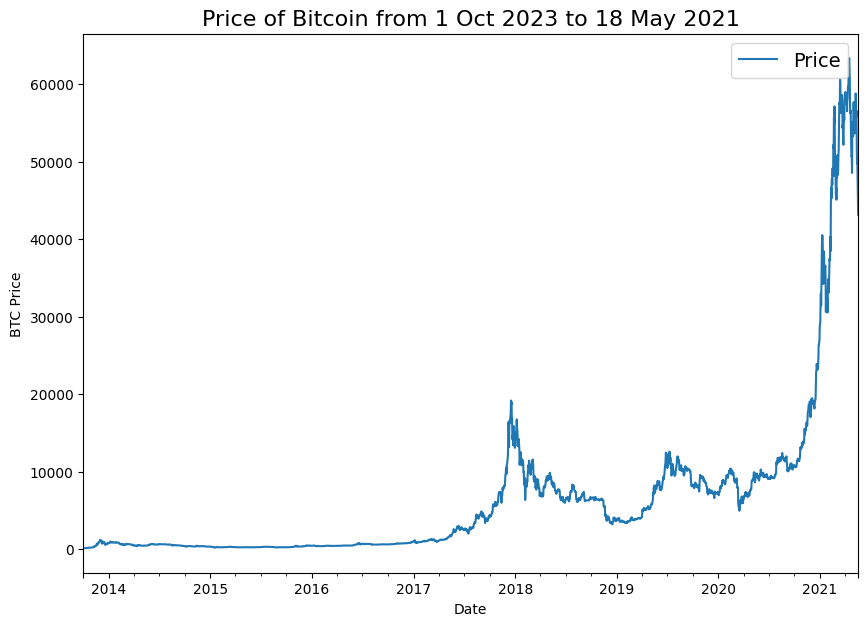

In [10]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2023 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Format data: Create train and test sets of the time series data above

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Create train and test splits
split_size = int(0.8 * len(prices)) # 80% train and 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [13]:
# Create function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of plot in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps: array of timesteps values
  values: array of values across time
  format: style of plot, defaul "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

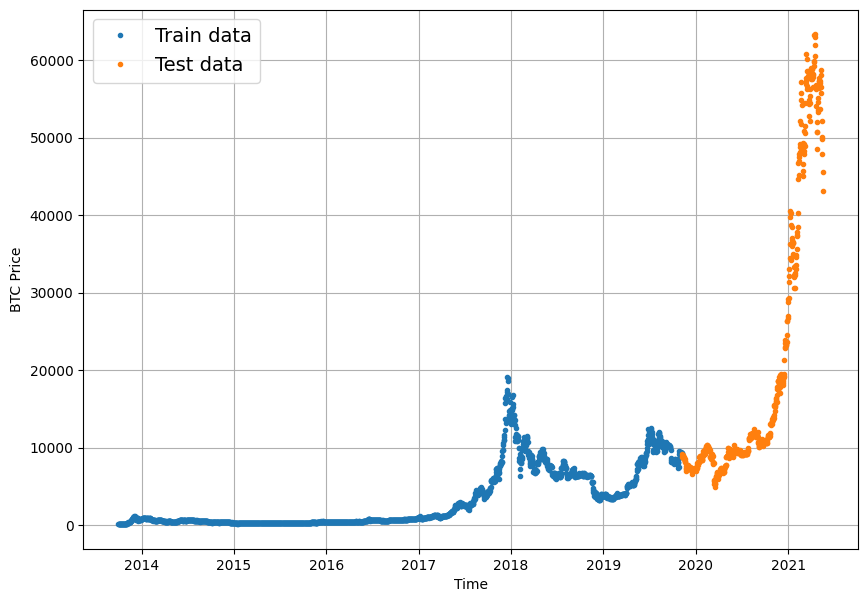

In [14]:
# Plot made splits
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

I will run several modelling experiments to see which one performs the best.

Terms to be familiar with:

* Horizon = number of timesteps into the future we're going to predict
* Window size = number of timesteps we're going to use to predict horizon

Modelling experiments I'll be running:

* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast model (the baseline)
More info here: https://otexts.com/fpp3/simple-methods.html

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (the y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[:-10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([ 9226.48582088,  8794.35864452,  8798.04205463,  9081.18687849,
         8711.53433917,  8760.89271814,  8749.52059102,  8656.97092235,
         8500.64355816,  8469.2608989 ,  8537.33965197,  8205.80636599,
         8118.4885358 ,  8074.84317361,  7612.7405735 ,  7262.11053495,
         7303.40575852,  7041.73293642,  7211.86180875,  7141.06944869,
         7523.4806726 ,  7390.20746923,  7729.26593894,  7542.23560864,
         7381.96300782,  7333.43293049,  7315.36776456,  7213.73376172,
         7398.78704961,  7511.88058312,  7532.12351309,  7550.23919987,
         7333.09604316,  7239.76257544,  7198.06667705,  7190.27236926,
         7238.87432299,  7087.02498535,  7112.73147612,  6883.49639377,
         6584.02884335,  7424.01540023,  7147.56832379,  7139.93337053,
         7286.33508116,  7236.98

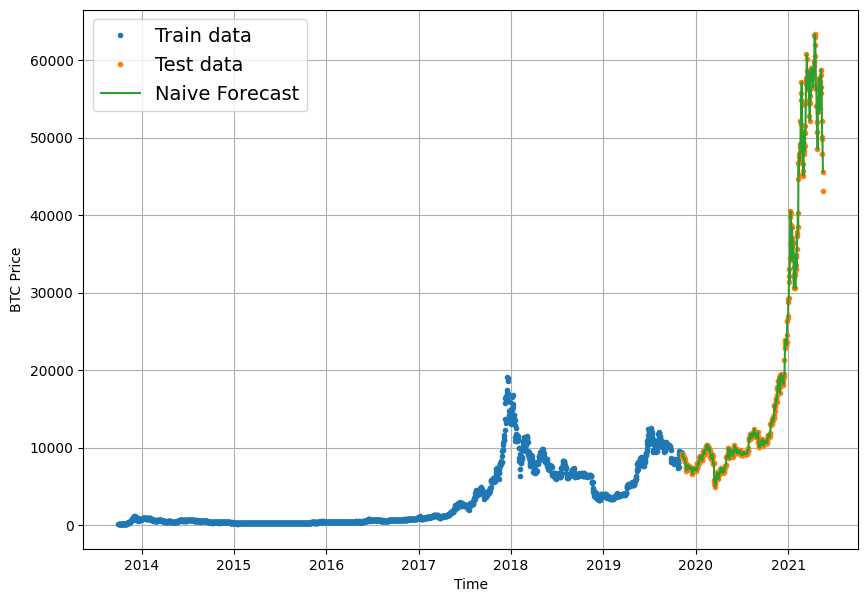

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

I'm predicting a number, so that means I have a form of regression problem.

Because it is a regression problem, I'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, lower is better, for example, an MAE of 0 that is better than an MAE of 100.

The main thing that I'm evaluating here is: how the model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mea_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1])) # our seasonality is 1 day (hence the shift is 1)
  
  return mae / mea_naive_no_season

In [18]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [19]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatyep (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float64)
  y_pred = tf.cast(y_pred, dtype=tf.float64)

  # Calculate various evaluation metrcs#
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for diffrent size metrics (for longer horizons, we want to reduce metrics to a singular value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802273457541,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624}

## Window the dataset

I need to window the serues dataset to turn the data into a supervised learning problem.

```
Ex:
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [21]:
bitcoin_prices["Price"][:7]

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
2013-10-04    118.67466
2013-10-05    121.33866
2013-10-06    120.65533
2013-10-07    121.79500
Name: Price, dtype: float64

In [22]:
# What I want to do with the Bitcoin data
print(f"I want to use this: {btc_prices[:7]} to predict this: {btc_prices[7]}")

I want to use this: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [23]:
# Global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [24]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [25]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8) + 1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [26]:
# Create function to view numpy arrays as windows by following this article:
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T # create 2D array of windows of size window_size

  # Index on the target array (a time series) with 2D array of multiple window steps
  window_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_labelled_windows(window_array, horizon=horizon)
  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [28]:
# View the first 3 windwos/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [29]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [30]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [31]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [32]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [33]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [34]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [35]:
train_labels[:5].shape

(5, 1)

## Make a modelling checkpoint callback

Because the model's performance will flactuate from experiment to experiment I need to write a model checkpoint so that I can compare a model's performance to anothers.

For example, if the model performs the best on epoch 55 out of 100, I would like to save the model's performance and weights on that checkpoint.

In [36]:
# Create a function to implement a ModelCheckoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="/content/drive/MyDrive/machine_learning_models"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(save_path, model_name),
      verbosity=0, # only output a limited amount of text
      save_best_only=True
  )

## Model 1: Dense model (window = 7, horizon = 1)

The first deep model is going to be a simple dense model and is going to have the following parameters:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128
* 100 epochs

Those parameters are picked to experiment and test this model to see it's performance.

In [37]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# Compile the model
model_1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_1.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 14s - loss: 2507.3066 - mae: 2507.3066 - mse: 13000399.0000

18/18 [==============================] - 3s 142ms/step - loss: 914.4750 - mae: 914.4750 - mse: 3172292.7500 - val_loss: 2540.6794 - val_mae: 2540.6794 - val_mse: 14983345.0000
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 256.2625 - mae: 256.2625 - mse: 295130.8438

18/18 [==============================] - 1s 77ms/step - loss: 253.7163 - mae: 253.7163 - mse: 290281.2500 - val_loss: 1112.1821 - val_mae: 1112.1821 - val_mse: 3963509.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 140.7189 - mae: 140.7189 - mse: 74088.5781

18/18 [==============================] - 1s 59ms/step - loss: 175.6093 - mae: 175.6093 - mse: 155285.6562 - val_loss: 883.8906 - val_mae: 883.8906 - val_mse: 2574528.5000
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 153.4682 - mae: 153.4682 - mse: 130570.7656 - val_loss: 891.3066 - val_mae: 891.3066 - val_mse: 2451973.5000
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 149.6936 - mae: 149.6936 - mse: 126824.2109

18/18 [==============================] - 1s 55ms/step - loss: 146.9758 - mae: 146.9758 - mse: 120419.3672 - val_loss: 806.8384 - val_mae: 806.8384 - val_mse: 2211501.0000
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 141.8259 - mae: 141.8259 - mse: 112162.2656 - val_loss: 832.3237 - val_mae: 832.3237 - val_mse: 2105769.2500
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 137.2056 - mae: 137.2056 - mse: 106704.1328 - val_loss: 828.9225 - val_mae: 828.9225 - val_mse: 2028400.6250
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 121.9647 - mae: 121.9647 - mse: 54243.0742

18/18 [==============================] - 1s 41ms/step - loss: 135.4402 - mae: 135.4402 - mse: 100674.5625 - val_loss: 719.7762 - val_mae: 719.7762 - val_mse: 1724349.5000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 119.3373 - mae: 119.3373 - mse: 74089.8828

18/18 [==============================] - 1s 41ms/step - loss: 130.1464 - mae: 130.1464 - mse: 92856.3281 - val_loss: 709.4578 - val_mae: 709.4578 - val_mse: 1644923.7500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 125.9255 - mae: 125.9255 - mse: 114236.4375

18/18 [==============================] - 1s 41ms/step - loss: 129.7163 - mae: 129.7163 - mse: 95361.2812 - val_loss: 686.9391 - val_mae: 686.9391 - val_mse: 1562526.7500
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 124.2361 - mae: 124.2361 - mse: 87272.4375 - val_loss: 778.9742 - val_mae: 778.9742 - val_mse: 1792106.8750
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 132.7455 - mae: 132.7455 - mse: 94499.4375 - val_loss: 867.6111 - val_mae: 867.6111 - val_mse: 2071777.6250
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 146.5143 - mae: 146.5143 - mse: 97303.1875

18/18 [==============================] - 1s 41ms/step - loss: 132.4822 - mae: 132.4822 - mse: 92921.9297 - val_loss: 673.6472 - val_mae: 673.6472 - val_mse: 1490338.3750
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 110.9558 - mae: 110.9558 - mse: 50620.7812

18/18 [==============================] - 1s 42ms/step - loss: 122.3579 - mae: 122.3579 - mse: 85734.0391 - val_loss: 653.0178 - val_mae: 653.0178 - val_mse: 1439040.2500
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 121.9765 - mae: 121.9765 - mse: 84310.7812 - val_loss: 659.4705 - val_mae: 659.4705 - val_mse: 1498965.7500
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 120.1634 - mae: 120.1634 - mse: 82609.2969 - val_loss: 678.8331 - val_mae: 678.8331 - val_mse: 1481384.8750
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 117.1969 - mae: 117.1969 - mse: 80170.1094 - val_loss: 682.9249 - val_mae: 682.9249 - val_mse: 1487894.5000
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1096 - mae: 134.1096 - mse: 95716.4297

18/18 [==============================] - 1s 41ms/step - loss: 116.4575 - mae: 116.4575 - mse: 79993.4297 - val_loss: 626.9825 - val_mae: 626.9825 - val_mse: 1365089.7500
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 118.1510 - mae: 118.1510 - mse: 80358.2266 - val_loss: 745.6004 - val_mae: 745.6004 - val_mse: 1649596.1250
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 139.5374 - mae: 139.5374 - mse: 93779.5469

18/18 [==============================] - 1s 42ms/step - loss: 119.2352 - mae: 119.2352 - mse: 78626.4219 - val_loss: 621.2571 - val_mae: 621.2571 - val_mse: 1338365.2500
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9188 - mae: 117.9188 - mse: 79390.8672 - val_loss: 639.3514 - val_mae: 639.3514 - val_mse: 1405577.6250
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 116.8209 - mae: 116.8209 - mse: 79659.2891 - val_loss: 638.4797 - val_mae: 638.4797 - val_mse: 1360726.7500
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 111.2679 - mae: 111.2679 - mse: 52778.0469

18/18 [==============================] - 1s 43ms/step - loss: 115.8405 - mae: 115.8405 - mse: 76909.4688 - val_loss: 610.7198 - val_mae: 610.7198 - val_mse: 1310636.7500
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2908 - mae: 113.2908 - mse: 77128.7500 - val_loss: 626.7270 - val_mae: 626.7270 - val_mse: 1326352.8750
Epoch 25/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8425 - mae: 111.8425 - mse: 75451.2969 - val_loss: 624.1416 - val_mae: 624.1416 - val_mse: 1349893.5000
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 110.9390 - mae: 110.9390 - mse: 62655.1211

18/18 [==============================] - 1s 41ms/step - loss: 112.8446 - mae: 112.8446 - mse: 75650.9219 - val_loss: 605.1111 - val_mae: 605.1111 - val_mse: 1276617.2500
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 116.1290 - mae: 116.1290 - mse: 76117.1250 - val_loss: 625.8820 - val_mae: 625.8820 - val_mse: 1347837.0000
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 104.3124 - mae: 104.3124 - mse: 58609.5664

18/18 [==============================] - 1s 43ms/step - loss: 112.7070 - mae: 112.7070 - mse: 76371.5703 - val_loss: 597.9840 - val_mae: 597.9840 - val_mse: 1260747.5000
Epoch 29/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4311 - mae: 112.4311 - mse: 74459.1328 - val_loss: 599.7177 - val_mae: 599.7177 - val_mse: 1271310.7500
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 122.9623 - mae: 122.9623 - mse: 83124.4844

18/18 [==============================] - 1s 42ms/step - loss: 113.9106 - mae: 113.9106 - mse: 75643.6641 - val_loss: 594.1448 - val_mae: 594.1448 - val_mse: 1252645.5000
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 112.1392 - mae: 112.1392 - mse: 72555.9375 - val_loss: 600.1059 - val_mae: 600.1059 - val_mse: 1251193.1250
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7271 - mae: 110.7271 - mse: 73765.5703 - val_loss: 610.8608 - val_mae: 610.8608 - val_mse: 1272790.5000
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1618 - mae: 110.1618 - mse: 71941.5859 - val_loss: 610.1582 - val_mae: 610.1582 - val_mse: 1268858.8750
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 109.8935 - mae: 109.8935 - mse: 73588.1562 - val_loss: 607.9349 - val_mae: 607.9349 - val_mse: 1286345.3750
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5637 - mae: 108.5637 - m

18/18 [==============================] - 1s 78ms/step - loss: 110.1172 - mae: 110.1172 - mse: 71835.8672 - val_loss: 586.1938 - val_mae: 586.1938 - val_mse: 1228099.8750
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9643 - mae: 108.9643 - mse: 71453.7969 - val_loss: 587.6472 - val_mae: 587.6472 - val_mse: 1231869.5000
Epoch 38/100
18/18 [==============================] - 0s 7ms/step - loss: 109.8352 - mae: 109.8352 - mse: 72032.2578 - val_loss: 602.4478 - val_mae: 602.4478 - val_mse: 1266559.7500
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8863 - mae: 122.8863 - mse: 101380.2578

18/18 [==============================] - 1s 57ms/step - loss: 108.7967 - mae: 108.7967 - mse: 71234.8672 - val_loss: 580.4253 - val_mae: 580.4253 - val_mse: 1208251.6250
Epoch 40/100
18/18 [==============================] - 0s 8ms/step - loss: 107.5181 - mae: 107.5181 - mse: 70925.7500 - val_loss: 586.7211 - val_mae: 586.7211 - val_mse: 1224705.3750
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 108.2911 - mae: 108.2911 - mse: 69933.1641 - val_loss: 584.2513 - val_mae: 584.2513 - val_mse: 1206318.7500
Epoch 42/100
18/18 [==============================] - 0s 8ms/step - loss: 114.2934 - mae: 114.2934 - mse: 75929.3828 - val_loss: 648.0135 - val_mae: 648.0135 - val_mse: 1337750.6250
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 116.8527 - mae: 116.8527 - mse: 71717.8281 - val_loss: 658.2816 - val_mae: 658.2816 - val_mse: 1405625.1250
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9319 - mae: 112.9319 - m

18/18 [==============================] - 1s 59ms/step - loss: 108.4870 - mae: 108.4870 - mse: 70983.0781 - val_loss: 574.3699 - val_mae: 574.3699 - val_mse: 1186136.1250
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9351 - mae: 108.9351 - mse: 70739.3125 - val_loss: 599.9184 - val_mae: 599.9184 - val_mse: 1228769.3750
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 113.2987 - mae: 113.2987 - mse: 73082.4297 - val_loss: 606.8776 - val_mae: 606.8776 - val_mse: 1243593.2500
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 113.5443 - mae: 113.5443 - mse: 72331.5391 - val_loss: 644.5401 - val_mae: 644.5401 - val_mse: 1359481.6250
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 112.1295 - mae: 112.1295 - mse: 71781.3984 - val_loss: 631.7180 - val_mae: 631.7180 - val_mse: 1297088.2500
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5473 - mae: 113.5473 - m

18/18 [==============================] - 1s 40ms/step - loss: 105.8960 - mae: 105.8960 - mse: 69000.5938 - val_loss: 571.5667 - val_mae: 571.5667 - val_mse: 1172101.5000
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 106.5137 - mae: 106.5137 - mse: 68376.8516 - val_loss: 574.0183 - val_mae: 574.0183 - val_mse: 1187056.1250
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 110.9613 - mae: 110.9613 - mse: 71057.2266 - val_loss: 660.6484 - val_mae: 660.6484 - val_mse: 1352208.3750
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 95.1015 - mae: 95.1015 - mse: 36834.7109

18/18 [==============================] - 1s 42ms/step - loss: 110.5799 - mae: 110.5799 - mse: 71032.3203 - val_loss: 571.3959 - val_mae: 571.3959 - val_mse: 1174335.2500
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 106.9143 - mae: 106.9143 - mse: 69641.2656 - val_loss: 573.7001 - val_mae: 573.7001 - val_mse: 1181972.6250
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 105.6483 - mae: 105.6483 - mse: 68570.6797 - val_loss: 574.8336 - val_mae: 574.8336 - val_mse: 1174057.5000
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 105.0229 - mae: 105.0229 - mse: 67974.4609 - val_loss: 627.3088 - val_mae: 627.3088 - val_mse: 1307845.2500
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 68.5994 - mae: 68.5994 - mse: 32318.5977

18/18 [==============================] - 1s 41ms/step - loss: 104.3469 - mae: 104.3469 - mse: 67038.4141 - val_loss: 570.0477 - val_mae: 570.0477 - val_mse: 1173530.2500
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5962 - mae: 107.5962 - mse: 68785.1016 - val_loss: 626.4105 - val_mae: 626.4105 - val_mse: 1274665.7500
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7779 - mae: 115.7779 - mse: 72508.0078 - val_loss: 647.0284 - val_mae: 647.0284 - val_mse: 1358675.1250
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 107.0460 - mae: 107.0460 - mse: 68567.2969 - val_loss: 573.8848 - val_mae: 573.8848 - val_mse: 1170304.2500
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4540 - mae: 110.4540 - mse: 70378.5469 - val_loss: 570.1489 - val_mae: 570.1489 - val_mse: 1162748.3750
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 111.9393 - mae: 111.9393 - m

18/18 [==============================] - 1s 42ms/step - loss: 107.4312 - mae: 107.4312 - mse: 69577.8672 - val_loss: 565.6266 - val_mae: 565.6266 - val_mse: 1157696.6250
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 104.4928 - mae: 104.4928 - mse: 66936.3984 - val_loss: 568.9836 - val_mae: 568.9836 - val_mse: 1163969.0000
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4266 - mae: 109.4266 - mse: 67769.7891 - val_loss: 604.7455 - val_mae: 604.7455 - val_mse: 1252769.6250
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6504 - mae: 108.6504 - mse: 71047.4766 - val_loss: 570.4557 - val_mae: 570.4557 - val_mse: 1171624.6250
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 105.5440 - mae: 105.5440 - mse: 68916.7266 - val_loss: 580.0778 - val_mae: 580.0778 - val_mse: 1177130.8750
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 104.8698 - mae: 104.8698 - m

18/18 [==============================] - 1s 43ms/step - loss: 104.7873 - mae: 104.7873 - mse: 66307.5156 - val_loss: 565.6245 - val_mae: 565.6245 - val_mse: 1155789.6250
Epoch 96/100
 1/18 [>.............................] - ETA: 0s - loss: 106.1919 - mae: 106.1919 - mse: 59805.4062

18/18 [==============================] - 1s 40ms/step - loss: 105.3406 - mae: 105.3406 - mse: 67235.3672 - val_loss: 564.5280 - val_mae: 564.5280 - val_mse: 1153690.0000
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 105.2139 - mae: 105.2139 - mse: 67383.4375 - val_loss: 564.6089 - val_mae: 564.6089 - val_mse: 1151934.5000
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 104.1798 - mae: 104.1798 - mse: 67564.1250 - val_loss: 571.6715 - val_mae: 571.6715 - val_mse: 1172924.1250
Epoch 99/100
18/18 [==============================] - 0s 4ms/step - loss: 105.5848 - mae: 105.5848 - mse: 68353.3672 - val_loss: 580.4830 - val_mae: 580.4830 - val_mse: 1174156.7500
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 113.5273 - mae: 113.5273 - mse: 69591.6406 - val_loss: 635.8576 - val_mae: 635.8576 - val_mse: 1290410.1250


In [38]:
# Evaluate model on test_data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 635.8575 - mae: 635.8575 - mse: 1290409.8750


[635.8575439453125, 635.8575439453125, 1290409.875]

In [39]:
# Load in the best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 564.5280 - mae: 564.5280 - mse: 1153690.0000


[564.5279541015625, 564.5279541015625, 1153690.0]

## Making forecasts with the model (on the test dataset)

To make "forecasts" in the test dataset (note: this won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future)"

Now to make those forecasts I'm going to create a function to do this:

(What the function parameters will be)
1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the prediction

In [40]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) #  return 1D array of predictions

In [41]:
# Make predicitons using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8839.79 , 8792.677, 9042.408, 8761.888, 8752.753, 8746.855,
        8667.564, 8533.18 , 8456.6  , 8534.385], dtype=float32)>)

In [42]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels), y_pred = model_1_preds)
model_1_results

{'mae': 564.527951111124,
 'mse': 1153689.8980102974,
 'rmse': 1074.0995754632331,
 'mape': 2.5373140770929306,
 'mase': 0.9917191466416637}

In [43]:
naive_results

{'mae': 567.9802273457541,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 2.516524929982267,
 'mase': 0.9995699939182624}

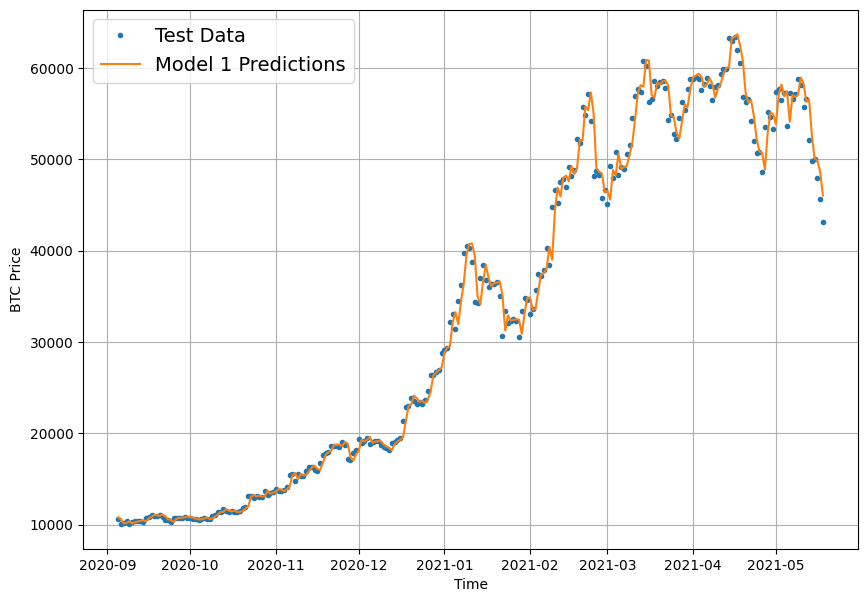

In [44]:
# Plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model 1 Predictions")

## Model 2: Dense model (window = 30, horizon = 1)

(Same as model 1 but different Hypeparameters)

In [45]:
WINDOW_SIZE = 30 # use 30 timesteps in the past
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)

In [46]:
# Make window data with appropiate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [47]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [48]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [49]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_2_dense")

# Compile the model
model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_2.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_2.name)]
)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1056.0627 - mae: 1056.0627 - mse: 4400383.0000  

18/18 [==============================] - 3s 144ms/step - loss: 1056.0627 - mae: 1056.0627 - mse: 4400383.0000 - val_loss: 3732.9819 - val_mae: 3732.9819 - val_mse: 32142132.0000
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 416.3755 - mae: 416.3755 - mse: 763979.9375 

18/18 [==============================] - 1s 43ms/step - loss: 416.3755 - mae: 416.3755 - mse: 763979.9375 - val_loss: 1818.0927 - val_mae: 1818.0927 - val_mse: 10609221.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 345.1806 - mae: 345.1806 - mse: 633231.1875

18/18 [==============================] - 1s 61ms/step - loss: 318.7013 - mae: 318.7013 - mse: 474846.5000 - val_loss: 1605.4600 - val_mae: 1605.4600 - val_mse: 8339251.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 212.3470 - mae: 212.3470 - mse: 251614.2031

18/18 [==============================] - 1s 42ms/step - loss: 272.6996 - mae: 272.6996 - mse: 363553.6250 - val_loss: 1568.1312 - val_mae: 1568.1312 - val_mse: 6943013.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 200.8239 - mae: 200.8239 - mse: 154784.4531

18/18 [==============================] - 1s 42ms/step - loss: 242.1817 - mae: 242.1817 - mse: 283817.5625 - val_loss: 1303.1864 - val_mae: 1303.1864 - val_mse: 5751166.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 295.9646 - mae: 295.9646 - mse: 446554.9062

18/18 [==============================] - 1s 41ms/step - loss: 238.5802 - mae: 238.5802 - mse: 265411.5312 - val_loss: 1177.4265 - val_mae: 1177.4265 - val_mse: 4114119.5000
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 196.7360 - mae: 196.7360 - mse: 201425.0781 - val_loss: 1285.6486 - val_mae: 1285.6486 - val_mse: 4441086.0000
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 190.5563 - mae: 190.5563 - mse: 183272.8750 - val_loss: 1268.3121 - val_mae: 1268.3121 - val_mse: 4279109.5000
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 215.3868 - mae: 215.3868 - mse: 242771.7188

18/18 [==============================] - 1s 45ms/step - loss: 178.4836 - mae: 178.4836 - mse: 167147.2812 - val_loss: 1067.7421 - val_mae: 1067.7421 - val_mse: 3278035.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 213.2962 - mae: 213.2962 - mse: 262134.9062

18/18 [==============================] - 1s 40ms/step - loss: 171.3033 - mae: 171.3033 - mse: 149990.8281 - val_loss: 914.8126 - val_mae: 914.8126 - val_mse: 2661527.7500
Epoch 11/100
18/18 [==============================] - 0s 4ms/step - loss: 158.3784 - mae: 158.3784 - mse: 134046.2500 - val_loss: 1036.7369 - val_mae: 1036.7369 - val_mse: 2981912.5000
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 126.0366 - mae: 126.0366 - mse: 65213.6914

18/18 [==============================] - 1s 41ms/step - loss: 161.9159 - mae: 161.9159 - mse: 134650.8906 - val_loss: 888.5546 - val_mae: 888.5546 - val_mse: 2404603.2500
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 147.9164 - mae: 147.9164 - mse: 94768.4688

18/18 [==============================] - 1s 40ms/step - loss: 154.4244 - mae: 154.4244 - mse: 129477.2812 - val_loss: 846.7688 - val_mae: 846.7688 - val_mse: 2354812.0000
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 148.3758 - mae: 148.3758 - mse: 119317.6406 - val_loss: 856.6015 - val_mae: 856.6015 - val_mse: 2174347.2500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 161.1595 - mae: 161.1595 - mse: 99114.0703

18/18 [==============================] - 1s 44ms/step - loss: 151.2714 - mae: 151.2714 - mse: 118292.5859 - val_loss: 810.8651 - val_mae: 810.8651 - val_mse: 2105787.2500
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 156.2191 - mae: 156.2191 - mse: 114358.2500 - val_loss: 1125.2094 - val_mae: 1125.2094 - val_mse: 3224503.7500
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 148.9738 - mae: 148.9738 - mse: 115100.7891 - val_loss: 1142.7943 - val_mae: 1142.7943 - val_mse: 3305227.2500
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 216.9933 - mae: 216.9933 - mse: 175610.1875

18/18 [==============================] - 1s 43ms/step - loss: 155.7249 - mae: 155.7249 - mse: 116858.9844 - val_loss: 777.7861 - val_mae: 777.7861 - val_mse: 1862781.5000
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 142.6183 - mae: 142.6183 - mse: 104686.7188 - val_loss: 1310.9443 - val_mae: 1310.9445 - val_mse: 4542737.0000
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 239.9275 - mae: 239.9275 - mse: 240438.7500

18/18 [==============================] - 1s 43ms/step - loss: 166.2056 - mae: 166.2056 - mse: 129021.9141 - val_loss: 759.0864 - val_mae: 759.0864 - val_mse: 1821225.1250
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 142.3465 - mae: 142.3465 - mse: 106702.3984 - val_loss: 1451.2249 - val_mae: 1451.2249 - val_mse: 4709508.5000
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 214.7108 - mae: 214.7108 - mse: 184680.1562 - val_loss: 823.0261 - val_mae: 823.0261 - val_mse: 2199714.2500
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 147.2244 - mae: 147.2244 - mse: 109042.6250 - val_loss: 1199.9401 - val_mae: 1199.9401 - val_mse: 3450840.7500
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 145.5487 - mae: 145.5487 - mse: 105956.5859 - val_loss: 773.0436 - val_mae: 773.0436 - val_mse: 1769479.1250
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 134.7806 - mae: 134.780

18/18 [==============================] - 1s 61ms/step - loss: 134.7806 - mae: 134.7806 - mse: 95976.8828 - val_loss: 721.3401 - val_mae: 721.3401 - val_mse: 1618846.1250
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 136.6898 - mae: 136.6898 - mse: 96522.0234 - val_loss: 799.1687 - val_mae: 799.1687 - val_mse: 1829132.0000
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 133.4612 - mae: 133.4612 - mse: 92197.0469 - val_loss: 979.7706 - val_mae: 979.7706 - val_mse: 2451474.5000
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 147.4638 - mae: 147.4638 - mse: 106423.6797 - val_loss: 819.6721 - val_mae: 819.6721 - val_mse: 2097744.7500
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 189.9478 - mae: 189.9478 - mse: 167039.2656

18/18 [==============================] - 1s 56ms/step - loss: 164.5004 - mae: 164.5004 - mse: 119917.5000 - val_loss: 701.5441 - val_mae: 701.5441 - val_mse: 1596800.7500
Epoch 30/100
11/18 [=================>............] - ETA: 0s - loss: 148.8050 - mae: 148.8050 - mse: 109352.8750

18/18 [==============================] - 1s 61ms/step - loss: 142.3393 - mae: 142.3393 - mse: 97577.3984 - val_loss: 696.9461 - val_mae: 696.9461 - val_mse: 1534068.5000
Epoch 31/100
18/18 [==============================] - 0s 9ms/step - loss: 142.0658 - mae: 142.0658 - mse: 99604.1719 - val_loss: 757.1974 - val_mae: 757.1974 - val_mse: 1675563.7500
Epoch 32/100
18/18 [==============================] - 0s 6ms/step - loss: 148.4841 - mae: 148.4841 - mse: 104071.4688 - val_loss: 1255.3711 - val_mae: 1255.3711 - val_mse: 3633267.0000
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 213.1731 - mae: 213.1731 - mse: 155246.9062

18/18 [==============================] - 1s 49ms/step - loss: 147.1330 - mae: 147.1330 - mse: 102496.6562 - val_loss: 690.0768 - val_mae: 690.0768 - val_mse: 1511844.6250
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 143.7343 - mae: 143.7343 - mse: 84692.0547

18/18 [==============================] - 1s 43ms/step - loss: 127.0599 - mae: 127.0599 - mse: 87338.5625 - val_loss: 678.8417 - val_mae: 678.8417 - val_mse: 1463530.5000
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 129.9809 - mae: 129.9809 - mse: 90833.6172 - val_loss: 695.3248 - val_mae: 695.3248 - val_mse: 1598404.6250
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 134.0919 - mae: 134.0919 - mse: 92051.2656 - val_loss: 773.6623 - val_mae: 773.6623 - val_mse: 1703535.7500
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 128.1239 - mae: 128.1239 - mse: 70811.0234

18/18 [==============================] - 1s 62ms/step - loss: 134.2153 - mae: 134.2153 - mse: 91338.9141 - val_loss: 670.4721 - val_mae: 670.4721 - val_mse: 1448448.0000
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 126.9086 - mae: 126.9086 - mse: 84430.8672 - val_loss: 749.9918 - val_mae: 749.9918 - val_mse: 1802057.2500
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 142.9828 - mae: 142.9828 - mse: 100085.2188 - val_loss: 1349.0188 - val_mae: 1349.0188 - val_mse: 4056115.5000
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 199.6928 - mae: 199.6928 - mse: 151174.8750 - val_loss: 670.8485 - val_mae: 670.8485 - val_mse: 1474723.6250
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 152.1695 - mae: 152.1695 - mse: 102517.5547 - val_loss: 701.5781 - val_mae: 701.5781 - val_mse: 1517229.7500
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 148.3192 - mae: 148.319

18/18 [==============================] - 1s 43ms/step - loss: 143.7997 - mae: 143.7997 - mse: 103934.8281 - val_loss: 658.1608 - val_mae: 658.1608 - val_mse: 1412927.1250
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 131.9398 - mae: 131.9398 - mse: 77951.4844

18/18 [==============================] - 1s 42ms/step - loss: 123.3349 - mae: 123.3349 - mse: 83286.6328 - val_loss: 657.5953 - val_mae: 657.5953 - val_mse: 1393536.8750
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 121.9755 - mae: 121.9755 - mse: 82842.4531 - val_loss: 668.6604 - val_mae: 668.6604 - val_mse: 1458787.3750
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 128.0666 - mae: 128.0666 - mse: 90791.9844 - val_loss: 687.9382 - val_mae: 687.9382 - val_mse: 1458310.2500
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 80.4385 - mae: 80.4385 - mse: 34234.8945

18/18 [==============================] - 1s 42ms/step - loss: 122.2440 - mae: 122.2440 - mse: 82775.8594 - val_loss: 649.0928 - val_mae: 649.0928 - val_mse: 1375508.3750
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 110.3839 - mae: 110.3839 - mse: 80308.7578

18/18 [==============================] - 1s 44ms/step - loss: 125.0351 - mae: 125.0351 - mse: 83494.9844 - val_loss: 648.6304 - val_mae: 648.6304 - val_mse: 1379418.2500
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 136.9657 - mae: 136.9657 - mse: 88802.1562 - val_loss: 854.9601 - val_mae: 854.9601 - val_mse: 2120071.0000
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 118.7551 - mae: 118.7551 - mse: 65617.3281

18/18 [==============================] - 1s 42ms/step - loss: 135.3614 - mae: 135.3614 - mse: 89268.7969 - val_loss: 643.6060 - val_mae: 643.6060 - val_mse: 1355381.5000
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 145.7502 - mae: 145.7502 - mse: 105917.5000 - val_loss: 645.9918 - val_mae: 645.9918 - val_mse: 1356773.1250
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 161.8168 - mae: 161.8168 - mse: 116888.6641 - val_loss: 645.1152 - val_mae: 645.1152 - val_mse: 1373171.7500
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 141.7199 - mae: 141.7199 - mse: 99540.3281 - val_loss: 1259.2048 - val_mae: 1259.2048 - val_mse: 3586512.7500
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 187.3189 - mae: 187.3189 - mse: 123847.5625

18/18 [==============================] - 1s 40ms/step - loss: 172.9462 - mae: 172.9462 - mse: 123810.9922 - val_loss: 642.3364 - val_mae: 642.3364 - val_mse: 1365219.6250
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 152.8095 - mae: 152.8095 - mse: 106585.0859 - val_loss: 736.4668 - val_mae: 736.4668 - val_mse: 1586164.1250
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 125.6485 - mae: 125.6485 - mse: 85899.7656 - val_loss: 648.8146 - val_mae: 648.8146 - val_mse: 1368915.7500
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 120.8143 - mae: 120.8143 - mse: 81042.2266 - val_loss: 754.9271 - val_mae: 754.9271 - val_mse: 1761869.2500
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 173.1739 - mae: 173.1739 - mse: 128661.4531 - val_loss: 713.4427 - val_mae: 713.4427 - val_mse: 1520168.1250
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 155.2981 - mae: 155.2981 

18/18 [==============================] - 1s 40ms/step - loss: 137.5392 - mae: 137.5392 - mse: 88190.1875 - val_loss: 630.6785 - val_mae: 630.6785 - val_mse: 1330115.7500
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 130.1138 - mae: 130.1138 - mse: 84694.1094 - val_loss: 721.8314 - val_mae: 721.8314 - val_mse: 1541610.3750
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 125.9407 - mae: 125.9407 - mse: 82354.4844 - val_loss: 712.9680 - val_mae: 712.9680 - val_mse: 1521579.6250
Epoch 68/100
18/18 [==============================] - 0s 11ms/step - loss: 128.2149 - mae: 128.2149 - mse: 85474.0000 - val_loss: 631.6474 - val_mae: 631.6474 - val_mse: 1313540.7500
Epoch 69/100
18/18 [==============================] - 0s 14ms/step - loss: 128.2819 - mae: 128.2819 - mse: 86236.8750 - val_loss: 835.4301 - val_mae: 835.4301 - val_mse: 1900904.7500
Epoch 70/100
18/18 [==============================] - 1s 34ms/step - loss: 136.5990 - mae: 136.5990 

18/18 [==============================] - 4s 205ms/step - loss: 119.0880 - mae: 119.0880 - mse: 79043.2500 - val_loss: 618.5324 - val_mae: 618.5324 - val_mse: 1281326.3750
Epoch 74/100
18/18 [==============================] - 0s 23ms/step - loss: 121.7673 - mae: 121.7673 - mse: 79963.6406 - val_loss: 730.4666 - val_mae: 730.4666 - val_mse: 1638637.2500
Epoch 75/100
18/18 [==============================] - 0s 8ms/step - loss: 131.4936 - mae: 131.4936 - mse: 86479.8203 - val_loss: 710.8313 - val_mae: 710.8313 - val_mse: 1508363.8750
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 120.0905 - mae: 120.0905 - mse: 78436.8750 - val_loss: 739.5101 - val_mae: 739.5101 - val_mse: 1590378.8750
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 121.8038 - mae: 121.8038 - mse: 77543.5938 - val_loss: 693.6181 - val_mae: 693.6181 - val_mse: 1463447.2500
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 117.9803 - mae: 117.9803 -

18/18 [==============================] - 1s 40ms/step - loss: 118.5523 - mae: 118.5523 - mse: 78313.1719 - val_loss: 615.6892 - val_mae: 615.6892 - val_mse: 1287779.7500
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3835 - mae: 113.3835 - mse: 74559.1172 - val_loss: 662.7108 - val_mae: 662.7108 - val_mse: 1376004.6250
Epoch 83/100
 1/18 [>.............................] - ETA: 0s - loss: 84.2988 - mae: 84.2988 - mse: 38258.1523

18/18 [==============================] - 1s 43ms/step - loss: 123.4080 - mae: 123.4080 - mse: 80170.3516 - val_loss: 614.2676 - val_mae: 614.2676 - val_mse: 1283940.0000
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 125.1908 - mae: 125.1908 - mse: 78985.9922 - val_loss: 1042.4127 - val_mae: 1042.4127 - val_mse: 2638622.5000
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 148.7176 - mae: 148.7176 - mse: 103311.6172 - val_loss: 716.3768 - val_mae: 716.3768 - val_mse: 1523405.0000
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 121.3401 - mae: 121.3401 - mse: 79720.4922 - val_loss: 628.6737 - val_mae: 628.6737 - val_mse: 1289610.6250
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8021 - mae: 117.8021 - mse: 75414.1406 - val_loss: 636.3142 - val_mae: 636.3142 - val_mse: 1345457.1250
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 114.4847 - mae: 114.4847 

18/18 [==============================] - 1s 41ms/step - loss: 119.4650 - mae: 119.4650 - mse: 77630.0547 - val_loss: 613.8622 - val_mae: 613.8622 - val_mse: 1257750.5000
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 112.5508 - mae: 112.5508 - mse: 74131.1328 - val_loss: 655.4009 - val_mae: 655.4009 - val_mse: 1353652.3750
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 116.3720 - mae: 116.3720 - mse: 74074.0703 - val_loss: 617.3133 - val_mae: 617.3133 - val_mse: 1258262.7500
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9737 - mae: 114.9737 - mse: 74133.1406 - val_loss: 758.6259 - val_mae: 758.6259 - val_mse: 1654673.3750
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 133.8199 - mae: 133.8199 - mse: 88149.4141 - val_loss: 645.1439 - val_mae: 645.1439 - val_mse: 1383004.8750
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 117.5540 - mae: 117.5540 - m

In [50]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 635.0616 - mae: 635.0616 - mse: 1325539.1250


[635.0616455078125, 635.0616455078125, 1325539.125]

In [51]:
# Load in the best performing model
model_2 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 613.8622 - mae: 613.8622 - mse: 1257750.6250


[613.8622436523438, 613.8622436523438, 1257750.625]

In [52]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [53]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_2_preds
)
model_2_results

{'mae': 613.8621845502272,
 'mse': 1257750.3199705328,
 'rmse': 1121.4946812047451,
 'mape': 2.7801949523546825,
 'mase': 1.0730370324080438}

In [54]:
model_1_results

{'mae': 564.527951111124,
 'mse': 1153689.8980102974,
 'rmse': 1074.0995754632331,
 'mape': 2.5373140770929306,
 'mase': 0.9917191466416637}

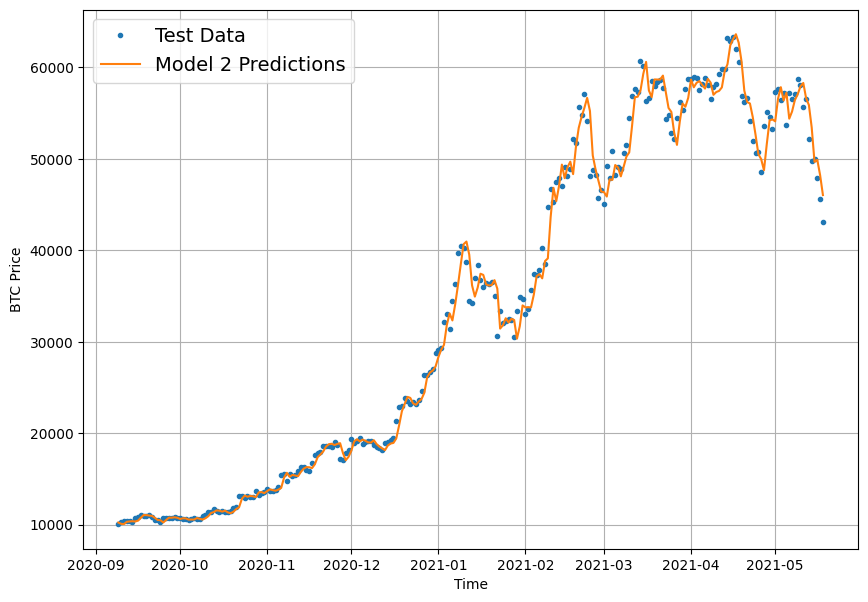

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

(Same as model 1 but different Hypeparameters)

In [56]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows = full_windows,
    labels = full_labels
)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [58]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")

# Compile the model
model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_3.fit(
    x = train_windows,
    y = train_labels,
    epochs=100,
    verbose=1,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_3.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 15s - loss: 3229.7031 - mae: 3229.7031 - mse: 25989736.0000

18/18 [==============================] - 4s 167ms/step - loss: 1344.8066 - mae: 1344.8066 - mse: 7011336.0000 - val_loss: 2770.6924 - val_mae: 2770.6924 - val_mse: 19542262.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 459.4437 - mae: 459.4437 - mse: 892384.9375

18/18 [==============================] - 1s 43ms/step - loss: 500.7002 - mae: 500.7002 - mse: 1127245.2500 - val_loss: 2465.6851 - val_mae: 2465.6851 - val_mse: 17368758.0000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 406.1718 - mae: 406.1718 - mse: 810394.5625

18/18 [==============================] - 1s 44ms/step - loss: 404.4278 - mae: 404.4278 - mse: 803417.8750 - val_loss: 2134.3582 - val_mae: 2134.3582 - val_mse: 13472292.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 442.0739 - mae: 442.0739 - mse: 983352.1250

18/18 [==============================] - 1s 43ms/step - loss: 367.4328 - mae: 367.4328 - mse: 691123.8125 - val_loss: 1844.7933 - val_mae: 1844.7933 - val_mse: 10695503.0000
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 342.9842 - mae: 342.9842 - mse: 607490.5000 - val_loss: 1980.9226 - val_mae: 1980.9226 - val_mse: 11962869.0000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 302.3221 - mae: 302.3221 - mse: 427259.9375

18/18 [==============================] - 1s 42ms/step - loss: 327.0987 - mae: 327.0987 - mse: 548210.3125 - val_loss: 1734.5505 - val_mae: 1734.5505 - val_mse: 9599155.0000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 284.1548 - mae: 284.1548 - mse: 452490.0625

18/18 [==============================] - 1s 43ms/step - loss: 311.4694 - mae: 311.4694 - mse: 498031.9375 - val_loss: 1566.0330 - val_mae: 1566.0330 - val_mse: 7981478.0000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 285.9491 - mae: 285.9491 - mse: 412750.4375

18/18 [==============================] - 1s 43ms/step - loss: 309.3572 - mae: 309.3572 - mse: 475950.9688 - val_loss: 1563.6901 - val_mae: 1563.6901 - val_mse: 7997978.0000
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 297.5721 - mae: 297.5721 - mse: 449058.5000 - val_loss: 1695.5132 - val_mae: 1695.5132 - val_mse: 8834806.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 257.4359 - mae: 257.4359 - mse: 266868.0000

18/18 [==============================] - 1s 44ms/step - loss: 296.6731 - mae: 296.6731 - mse: 436277.9688 - val_loss: 1530.1693 - val_mae: 1530.1693 - val_mse: 7620568.0000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 292.2183 - mae: 292.2183 - mse: 459106.6875

18/18 [==============================] - 1s 43ms/step - loss: 288.5240 - mae: 288.5240 - mse: 420046.7812 - val_loss: 1490.4446 - val_mae: 1490.4446 - val_mse: 7369786.5000
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 279.2792 - mae: 279.2792 - mse: 404697.5312 - val_loss: 1658.2172 - val_mae: 1658.2172 - val_mse: 8512533.0000
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 278.1357 - mae: 278.1357 - mse: 398028.8125 - val_loss: 1498.7036 - val_mae: 1498.7036 - val_mse: 7357110.0000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 279.1646 - mae: 279.1646 - mse: 373404.7812

18/18 [==============================] - 1s 41ms/step - loss: 274.7917 - mae: 274.7917 - mse: 396075.9375 - val_loss: 1469.2366 - val_mae: 1469.2366 - val_mse: 7226754.0000
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 271.8124 - mae: 271.8124 - mse: 386104.2500 - val_loss: 1539.0000 - val_mae: 1539.0000 - val_mse: 7532321.0000
Epoch 16/100
18/18 [==============================] - 0s 4ms/step - loss: 267.5488 - mae: 267.5488 - mse: 375857.5938 - val_loss: 1495.1591 - val_mae: 1495.1591 - val_mse: 7222994.5000
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 270.0154 - mae: 270.0154 - mse: 380562.3125 - val_loss: 1557.4148 - val_mae: 1557.4148 - val_mse: 7706579.5000
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 263.3134 - mae: 263.3134 - mse: 365695.4062 - val_loss: 1536.3558 - val_mae: 1536.3558 - val_mse: 7431380.0000
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 261.3951 - ma

18/18 [==============================] - 1s 43ms/step - loss: 265.8774 - mae: 265.8774 - mse: 365386.6562 - val_loss: 1407.0413 - val_mae: 1407.0413 - val_mse: 6731054.5000
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 259.2320 - mae: 259.2320 - mse: 353128.5938 - val_loss: 1477.5342 - val_mae: 1477.5342 - val_mse: 7070678.5000
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 338.4180 - mae: 338.4180 - mse: 508369.6250

18/18 [==============================] - 1s 41ms/step - loss: 259.3077 - mae: 259.3077 - mse: 353307.9688 - val_loss: 1404.6182 - val_mae: 1404.6182 - val_mse: 6696273.0000
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 261.6978 - mae: 261.6978 - mse: 355380.4688 - val_loss: 1457.9248 - val_mae: 1457.9248 - val_mse: 7115160.0000
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 279.3490 - mae: 279.3490 - mse: 386450.1562 - val_loss: 1458.6678 - val_mae: 1458.6680 - val_mse: 6876564.0000
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 258.2193 - mae: 258.2193 - mse: 351006.7500 - val_loss: 1537.1357 - val_mae: 1537.1357 - val_mse: 7275423.5000
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 250.6595 - mae: 250.6595 - mse: 300121.2500

18/18 [==============================] - 1s 56ms/step - loss: 251.8341 - mae: 251.8341 - mse: 337854.9375 - val_loss: 1400.3610 - val_mae: 1400.3610 - val_mse: 6535159.5000
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 248.4390 - mae: 248.4390 - mse: 337288.3438 - val_loss: 1468.7457 - val_mae: 1468.7457 - val_mse: 6784207.0000
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 249.4271 - mae: 249.4271 - mse: 334038.4062 - val_loss: 1420.9104 - val_mae: 1420.9104 - val_mse: 6704588.0000
Epoch 29/100
18/18 [==============================] - ETA: 0s - loss: 248.5280 - mae: 248.5280 - mse: 331696.2188

18/18 [==============================] - 1s 59ms/step - loss: 248.5280 - mae: 248.5280 - mse: 331696.2188 - val_loss: 1377.3181 - val_mae: 1377.3181 - val_mse: 6439948.5000
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 249.3969 - mae: 249.3969 - mse: 337376.4375 - val_loss: 1385.4886 - val_mae: 1385.4886 - val_mse: 6509206.0000
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 207.6147 - mae: 207.6147 - mse: 248916.3906

18/18 [==============================] - 1s 61ms/step - loss: 244.4937 - mae: 244.4937 - mse: 323374.1250 - val_loss: 1344.5419 - val_mae: 1344.5419 - val_mse: 6307471.0000
Epoch 32/100
18/18 [==============================] - 0s 7ms/step - loss: 246.0262 - mae: 246.0262 - mse: 327998.7812 - val_loss: 1373.2877 - val_mae: 1373.2877 - val_mse: 6457146.0000
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 244.9419 - mae: 244.9419 - mse: 324280.4062 - val_loss: 1368.6847 - val_mae: 1368.6847 - val_mse: 6265382.0000
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 244.2062 - mae: 244.2062 - mse: 323510.8438 - val_loss: 1432.6835 - val_mae: 1432.6835 - val_mse: 6697022.5000
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 245.2614 - mae: 245.2614 - mse: 322385.6875 - val_loss: 1389.1685 - val_mae: 1389.1685 - val_mse: 6492241.0000
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 244.2653 - ma

18/18 [==============================] - 1s 43ms/step - loss: 245.8948 - mae: 245.8948 - mse: 323090.5000 - val_loss: 1323.5927 - val_mae: 1323.5927 - val_mse: 6041387.0000
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 277.9004 - mae: 277.9004 - mse: 437276.0312

18/18 [==============================] - 1s 64ms/step - loss: 235.9298 - mae: 235.9298 - mse: 306106.9375 - val_loss: 1321.5825 - val_mae: 1321.5825 - val_mse: 5985472.0000
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 237.5781 - mae: 237.5781 - mse: 346768.5000

18/18 [==============================] - 1s 44ms/step - loss: 240.3441 - mae: 240.3441 - mse: 308981.1875 - val_loss: 1319.0848 - val_mae: 1319.0848 - val_mse: 5993337.0000
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 238.2979 - mae: 238.2979 - mse: 307183.6250 - val_loss: 1538.9072 - val_mae: 1538.9072 - val_mse: 7009820.5000
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 251.1779 - mae: 251.1779 - mse: 325386.1250 - val_loss: 1340.6813 - val_mae: 1340.6813 - val_mse: 6054536.5000
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 239.7988 - mae: 239.7988 - mse: 312174.9375 - val_loss: 1495.0698 - val_mae: 1495.0698 - val_mse: 6881673.0000
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 241.9466 - mae: 241.9466 - mse: 311395.2188 - val_loss: 1354.4242 - val_mae: 1354.4242 - val_mse: 6224831.0000
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 255.5151 - ma

18/18 [==============================] - 1s 43ms/step - loss: 232.5516 - mae: 232.5516 - mse: 296972.4062 - val_loss: 1306.8752 - val_mae: 1306.8752 - val_mse: 5908824.0000
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 236.4296 - mae: 236.4296 - mse: 298612.4062 - val_loss: 1341.2269 - val_mae: 1341.2269 - val_mse: 5993280.5000
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 233.9708 - mae: 233.9708 - mse: 295455.7812 - val_loss: 1356.3094 - val_mae: 1356.3094 - val_mse: 6087567.0000
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 234.9703 - mae: 234.9703 - mse: 298157.5938 - val_loss: 1342.3517 - val_mae: 1342.3517 - val_mse: 5945837.5000
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 236.0489 - mae: 236.0489 - mse: 300664.0312 - val_loss: 1376.6965 - val_mae: 1376.6965 - val_mse: 6206676.5000
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 230.1073 - mae: 2

18/18 [==============================] - 1s 43ms/step - loss: 235.5169 - mae: 235.5169 - mse: 297662.5000 - val_loss: 1302.5641 - val_mae: 1302.5641 - val_mse: 5815234.5000
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 184.1841 - mae: 184.1841 - mse: 214835.0938

18/18 [==============================] - 1s 43ms/step - loss: 232.9356 - mae: 232.9356 - mse: 294113.4688 - val_loss: 1300.8538 - val_mae: 1300.8538 - val_mse: 5859350.5000
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 220.4081 - mae: 220.4081 - mse: 230941.5938

18/18 [==============================] - 1s 43ms/step - loss: 234.5466 - mae: 234.5466 - mse: 293491.2500 - val_loss: 1294.8344 - val_mae: 1294.8344 - val_mse: 5791653.0000
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 228.5066 - mae: 228.5066 - mse: 287371.4062 - val_loss: 1388.1335 - val_mae: 1388.1335 - val_mse: 6223145.5000
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 347.8093 - mae: 347.8093 - mse: 554387.1875

18/18 [==============================] - 1s 42ms/step - loss: 237.7703 - mae: 237.7703 - mse: 298156.8438 - val_loss: 1281.5466 - val_mae: 1281.5466 - val_mse: 5819444.5000
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 237.1164 - mae: 237.1164 - mse: 297330.7500 - val_loss: 1445.4762 - val_mae: 1445.4762 - val_mse: 6628646.0000
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 235.6980 - mae: 235.6980 - mse: 294416.0312 - val_loss: 1283.9843 - val_mae: 1283.9843 - val_mse: 5745941.5000
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 229.7526 - mae: 229.7526 - mse: 289500.9062 - val_loss: 1313.7548 - val_mae: 1313.7548 - val_mse: 5811248.5000
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 231.2282 - mae: 231.2282 - mse: 286448.1875 - val_loss: 1508.9526 - val_mae: 1508.9526 - val_mse: 6843921.5000
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 250.6446 - mae: 2

18/18 [==============================] - 1s 42ms/step - loss: 239.1356 - mae: 239.1356 - mse: 300102.4062 - val_loss: 1279.8411 - val_mae: 1279.8411 - val_mse: 5641500.5000
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 233.2083 - mae: 233.2083 - mse: 290157.9375 - val_loss: 1328.1469 - val_mae: 1328.1469 - val_mse: 5918205.5000
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 231.5031 - mae: 231.5031 - mse: 280588.2500 - val_loss: 1530.1313 - val_mae: 1530.1313 - val_mse: 6933754.5000
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 232.9087 - mae: 232.9087 - mse: 289303.9688 - val_loss: 1310.4955 - val_mae: 1310.4955 - val_mse: 5774766.0000
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 193.2953 - mae: 193.2953 - mse: 161197.4844

18/18 [==============================] - 1s 42ms/step - loss: 229.9962 - mae: 229.9962 - mse: 288844.1562 - val_loss: 1265.9315 - val_mae: 1265.9315 - val_mse: 5574436.5000
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 230.4029 - mae: 230.4029 - mse: 285385.3125 - val_loss: 1270.7716 - val_mae: 1270.7716 - val_mse: 5620323.5000
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 224.9713 - mae: 224.9713 - mse: 279095.1250 - val_loss: 1290.8384 - val_mae: 1290.8384 - val_mse: 5698033.0000
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 227.1519 - mae: 227.1519 - mse: 283926.0625 - val_loss: 1375.1147 - val_mae: 1375.1147 - val_mse: 6046436.5000
Epoch 75/100
18/18 [==============================] - 0s 10ms/step - loss: 228.1672 - mae: 228.1672 - mse: 280012.5000 - val_loss: 1390.9541 - val_mae: 1390.9541 - val_mse: 6158273.5000
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 232.5329 - m

18/18 [==============================] - 1s 61ms/step - loss: 224.0133 - mae: 224.0133 - mse: 278620.9688 - val_loss: 1259.4058 - val_mae: 1259.4058 - val_mse: 5573260.5000
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 223.5876 - mae: 223.5876 - mse: 275235.4688 - val_loss: 1308.8406 - val_mae: 1308.8406 - val_mse: 5730726.5000
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 224.1436 - mae: 224.1436 - mse: 274815.0312 - val_loss: 1314.3462 - val_mae: 1314.3462 - val_mse: 5744553.5000
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 229.6180 - mae: 229.6180 - mse: 280306.6562 - val_loss: 1418.8213 - val_mae: 1418.8213 - val_mse: 6257760.0000
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 231.7531 - mae: 231.7531 - mse: 283400.5938 - val_loss: 1437.3669 - val_mae: 1437.3669 - val_mse: 6197692.5000
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 228.7139 - ma

18/18 [==============================] - 1s 59ms/step - loss: 235.5749 - mae: 235.5749 - mse: 287206.5312 - val_loss: 1248.3135 - val_mae: 1248.3135 - val_mse: 5503073.5000
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 227.6930 - mae: 227.6930 - mse: 278502.9375 - val_loss: 1267.6049 - val_mae: 1267.6049 - val_mse: 5651233.5000
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 228.8234 - mae: 228.8234 - mse: 279666.4062 - val_loss: 1427.9485 - val_mae: 1427.9485 - val_mse: 6301907.5000
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 229.7256 - mae: 229.7256 - mse: 281326.1875 - val_loss: 1271.4755 - val_mae: 1271.4755 - val_mse: 5508861.5000
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 225.6164 - mae: 225.6164 - mse: 274941.1250 - val_loss: 1280.8699 - val_mae: 1280.8699 - val_mse: 5656998.0000
Epoch 96/100
18/18 [==============================] - 0s 4ms/step - loss: 227.3735 - ma

In [59]:
# Evaluate model 2 on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1397.5869 - mae: 1397.5869 - mse: 6129902.0000


[1397.5869140625, 1397.5869140625, 6129902.0]

In [60]:
# Load in the best performing model
model_3 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1248.3136 - mae: 1248.3136 - mse: 5503073.5000


[1248.3135986328125, 1248.3135986328125, 5503073.5]

In [61]:
# Get the forecasting predictions for model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [62]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_3_preds
)
model_3_results

{'mae': 1248.313523632133,
 'mse': 5503073.386418132,
 'rmse': 1434.2741871604717,
 'mape': 5.59298640485191,
 'mase': 2.2213039457183856}

In [63]:
model_1_results, model_2_results

({'mae': 564.527951111124,
  'mse': 1153689.8980102974,
  'rmse': 1074.0995754632331,
  'mape': 2.5373140770929306,
  'mase': 0.9917191466416637},
 {'mae': 613.8621845502272,
  'mse': 1257750.3199705328,
  'rmse': 1121.4946812047451,
  'mape': 2.7801949523546825,
  'mase': 1.0730370324080438})

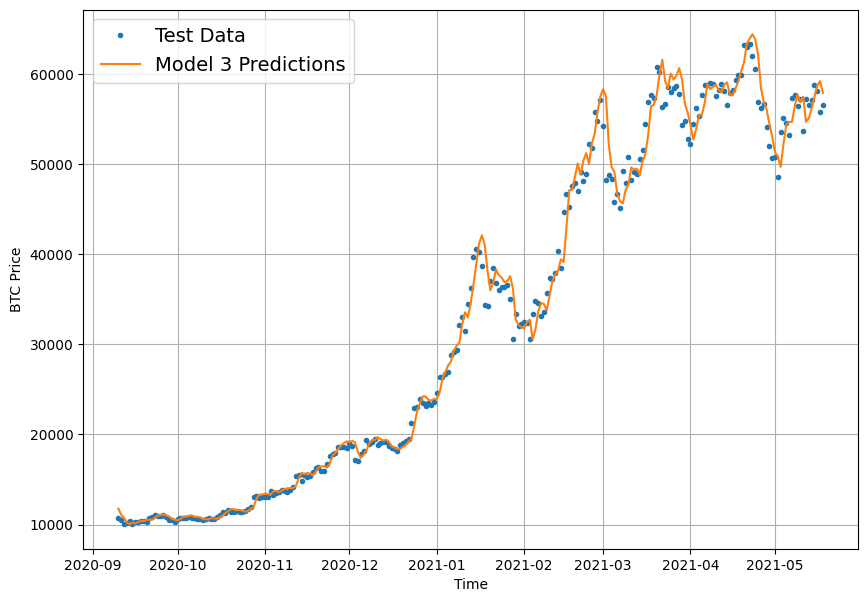

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-", label="Model 3 Predictions")

## Comparing the models build so far to see how well they performed

<Axes: >

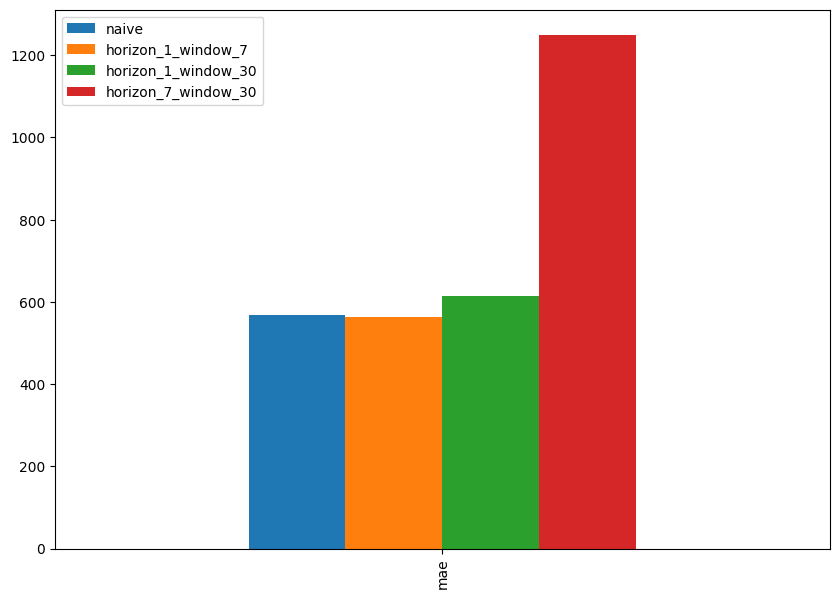

In [65]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar")

Note: You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

## Model 4: Conv1D

In [66]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [67]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [68]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However the data isn't in that shape yet

In [69]:
# Check data input shape
train_windows[0].shape # returns (WINDOWS_SIZE, )

(7,)

In [70]:
# Before I pass the data to the Conv1D layer, I will need to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [71]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an exate dimension for input dim

In [72]:
# Test the lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE, )
print(f"Expanded shape: {expand_dims_layer(x).shape}") # output =  (WINDOW_SIZE, HORIZON)
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [73]:
# Set random seed
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear", name="output_layer")
], name="model_4_Conv1D")

# Compile the model
model_4.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_4.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)]
)

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1938.8619 - mae: 1938.8619 - mse: 11052981.0000 

18/18 [==============================] - 4s 179ms/step - loss: 1902.9896 - mae: 1902.9896 - mse: 10819393.0000 - val_loss: 1269.2863 - val_mae: 1269.2863 - val_mse: 4339845.5000
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 339.8006 - mae: 339.8006 - mse: 452398.8438 - val_loss: 1631.2192 - val_mae: 1631.2192 - val_mse: 6439695.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 215.5872 - mae: 215.5872 - mse: 161596.6875

18/18 [==============================] - 1s 57ms/step - loss: 224.7816 - mae: 224.7816 - mse: 238639.2969 - val_loss: 1030.1200 - val_mae: 1030.1200 - val_mse: 3432529.5000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 230.1232 - mae: 230.1232 - mse: 264023.6562

18/18 [==============================] - 1s 57ms/step - loss: 187.2784 - mae: 187.2784 - mse: 178637.4531 - val_loss: 1001.0410 - val_mae: 1001.0410 - val_mse: 3376249.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 189.0019 - mae: 189.0019 - mse: 128132.4531

18/18 [==============================] - 1s 58ms/step - loss: 180.9259 - mae: 180.9259 - mse: 172427.9062 - val_loss: 999.9777 - val_mae: 999.9777 - val_mse: 3272564.2500
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 135.8435 - mae: 135.8435 - mse: 68565.7891

18/18 [==============================] - 1s 55ms/step - loss: 176.4739 - mae: 176.4739 - mse: 165594.0938 - val_loss: 980.7930 - val_mae: 980.7930 - val_mse: 3258315.5000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 218.7239 - mae: 218.7239 - mse: 335598.2500

18/18 [==============================] - 1s 57ms/step - loss: 174.2900 - mae: 174.2900 - mse: 162186.4531 - val_loss: 965.6829 - val_mae: 965.6829 - val_mse: 3096650.0000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 151.1162 - mae: 151.1162 - mse: 89935.0859

18/18 [==============================] - 1s 54ms/step - loss: 170.8304 - mae: 170.8304 - mse: 156510.3438 - val_loss: 958.3647 - val_mae: 958.3647 - val_mse: 3015149.5000
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 168.8127 - mae: 168.8127 - mse: 153450.3125 - val_loss: 971.0468 - val_mae: 971.0468 - val_mse: 2983397.2500
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 184.6659 - mae: 184.6659 - mse: 234875.4688

18/18 [==============================] - 1s 57ms/step - loss: 166.0215 - mae: 166.0215 - mse: 149164.5312 - val_loss: 917.7136 - val_mae: 917.7136 - val_mse: 2823509.2500
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 185.0230 - mae: 185.0230 - mse: 143332.5000

18/18 [==============================] - 1s 71ms/step - loss: 163.3822 - mae: 163.3822 - mse: 143778.7656 - val_loss: 900.3929 - val_mae: 900.3929 - val_mse: 2731315.5000
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 160.3796 - mae: 160.3796 - mse: 138870.2500 - val_loss: 952.4694 - val_mae: 952.4694 - val_mse: 2772454.2500
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 158.4960 - mae: 158.4960 - mse: 137380.8125

18/18 [==============================] - 1s 78ms/step - loss: 158.4960 - mae: 158.4960 - mse: 137380.8125 - val_loss: 888.8342 - val_mae: 888.8342 - val_mse: 2568531.2500
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 154.3931 - mae: 154.3931 - mse: 130658.6328 - val_loss: 896.9974 - val_mae: 896.9974 - val_mse: 2529522.7500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 154.3925 - mae: 154.3925 - mse: 84083.5469

18/18 [==============================] - 1s 80ms/step - loss: 154.2057 - mae: 154.2057 - mse: 130267.3516 - val_loss: 886.5767 - val_mae: 886.5767 - val_mse: 2454491.5000
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 150.7916 - mae: 150.7916 - mse: 125050.5156

18/18 [==============================] - 1s 86ms/step - loss: 149.1670 - mae: 149.1670 - mse: 122864.3594 - val_loss: 840.2527 - val_mae: 840.2527 - val_mse: 2303354.0000
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 146.3171 - mae: 146.3171 - mse: 118580.6562 - val_loss: 857.2868 - val_mae: 857.2868 - val_mse: 2292976.7500
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 153.6842 - mae: 153.6842 - mse: 104578.9141

18/18 [==============================] - 1s 58ms/step - loss: 144.6161 - mae: 144.6161 - mse: 116726.7812 - val_loss: 821.9384 - val_mae: 821.9384 - val_mse: 2168729.7500
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 80.3214 - mae: 80.3214 - mse: 32400.3711

18/18 [==============================] - 1s 57ms/step - loss: 140.5694 - mae: 140.5694 - mse: 110886.2891 - val_loss: 817.1841 - val_mae: 817.1841 - val_mse: 2117803.5000
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 151.6910 - mae: 151.6910 - mse: 130366.7422

18/18 [==============================] - 1s 56ms/step - loss: 141.3750 - mae: 141.3750 - mse: 111903.4844 - val_loss: 802.0234 - val_mae: 802.0234 - val_mse: 2158610.0000
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 199.6875 - mae: 199.6875 - mse: 178240.6094

18/18 [==============================] - 1s 53ms/step - loss: 140.2760 - mae: 140.2760 - mse: 109777.9531 - val_loss: 751.8881 - val_mae: 751.8881 - val_mse: 1937443.8750
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 184.0000 - mae: 184.0000 - mse: 209987.3750

18/18 [==============================] - 1s 57ms/step - loss: 136.7458 - mae: 136.7458 - mse: 104400.9453 - val_loss: 740.3285 - val_mae: 740.3285 - val_mse: 1851758.8750
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 147.5927 - mae: 147.5927 - mse: 102102.7188

18/18 [==============================] - 1s 56ms/step - loss: 132.2345 - mae: 132.2345 - mse: 99531.3906 - val_loss: 737.7250 - val_mae: 737.7250 - val_mse: 1804446.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 143.4819 - mae: 143.4819 - mse: 89300.6406

18/18 [==============================] - 1s 58ms/step - loss: 132.5645 - mae: 132.5645 - mse: 98361.8906 - val_loss: 726.2601 - val_mae: 726.2601 - val_mse: 1751075.0000
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 136.0779 - mae: 136.0779 - mse: 77075.3828

18/18 [==============================] - 1s 56ms/step - loss: 130.3122 - mae: 130.3122 - mse: 95827.3125 - val_loss: 707.3857 - val_mae: 707.3857 - val_mse: 1697623.1250
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 128.5679 - mae: 128.5679 - mse: 93583.9609 - val_loss: 725.0490 - val_mae: 725.0490 - val_mse: 1779720.0000
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 195.0648 - mae: 195.0648 - mse: 184014.2500

18/18 [==============================] - 1s 55ms/step - loss: 128.1411 - mae: 128.1411 - mse: 94478.3594 - val_loss: 691.8381 - val_mae: 691.8381 - val_mse: 1648214.1250
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 123.9338 - mae: 123.9338 - mse: 88729.4609

18/18 [==============================] - 1s 81ms/step - loss: 123.9338 - mae: 123.9338 - mse: 88729.4609 - val_loss: 687.9604 - val_mae: 687.9604 - val_mse: 1582091.6250
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 117.0659 - mae: 117.0659 - mse: 76538.2734

18/18 [==============================] - 2s 109ms/step - loss: 122.5327 - mae: 122.5327 - mse: 87102.2891 - val_loss: 672.0845 - val_mae: 672.0845 - val_mse: 1545694.1250
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 126.1702 - mae: 126.1702 - mse: 87910.6562 - val_loss: 680.6666 - val_mae: 680.6666 - val_mse: 1536076.0000
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 122.1758 - mae: 122.1758 - mse: 84252.7109 - val_loss: 719.5983 - val_mae: 719.5983 - val_mse: 1620154.0000
Epoch 32/100
18/18 [==============================] - 0s 7ms/step - loss: 123.8171 - mae: 123.8171 - mse: 87476.5000 - val_loss: 677.2655 - val_mae: 677.2655 - val_mse: 1508014.0000
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 119.2784 - mae: 119.2784 - mse: 83263.7578 - val_loss: 707.6349 - val_mae: 707.6349 - val_mse: 1574013.7500
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 120.1169 - mae: 120.1169 - mse:

18/18 [==============================] - 1s 60ms/step - loss: 120.8253 - mae: 120.8253 - mse: 84217.1016 - val_loss: 647.3601 - val_mae: 647.3601 - val_mse: 1427054.3750
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 104.2341 - mae: 104.2341 - mse: 52844.8867

18/18 [==============================] - 1s 57ms/step - loss: 118.9900 - mae: 118.9900 - mse: 83550.8672 - val_loss: 639.5239 - val_mae: 639.5239 - val_mse: 1403727.3750
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 123.7295 - mae: 123.7295 - mse: 82981.0156 - val_loss: 698.9434 - val_mae: 698.9434 - val_mse: 1534930.1250
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 151.5726 - mae: 151.5726 - mse: 118032.8594

18/18 [==============================] - 1s 55ms/step - loss: 122.5686 - mae: 122.5686 - mse: 84442.9609 - val_loss: 628.0640 - val_mae: 628.0640 - val_mse: 1384275.3750
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 107.5961 - mae: 107.5961 - mse: 72095.2734

18/18 [==============================] - 1s 58ms/step - loss: 116.6254 - mae: 116.6254 - mse: 81169.5625 - val_loss: 624.2156 - val_mae: 624.2156 - val_mse: 1373340.7500
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 115.9980 - mae: 115.9980 - mse: 79395.7422 - val_loss: 634.0871 - val_mae: 634.0871 - val_mse: 1402948.1250
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 109.3649 - mae: 109.3649 - mse: 99820.0781

18/18 [==============================] - 1s 55ms/step - loss: 114.4385 - mae: 114.4385 - mse: 79076.0469 - val_loss: 621.4096 - val_mae: 621.4096 - val_mse: 1339403.7500
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9899 - mae: 114.9899 - mse: 79133.0312 - val_loss: 634.0285 - val_mae: 634.0285 - val_mse: 1394276.3750
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 111.4507 - mae: 111.4507 - mse: 63378.1953

18/18 [==============================] - 1s 56ms/step - loss: 119.0635 - mae: 119.0635 - mse: 82145.0781 - val_loss: 617.3245 - val_mae: 617.3245 - val_mse: 1322074.6250
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2137 - mae: 115.2137 - mse: 77494.2266 - val_loss: 618.0346 - val_mae: 618.0346 - val_mse: 1346094.0000
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 67.6868 - mae: 67.6868 - mse: 16769.7715

18/18 [==============================] - 1s 56ms/step - loss: 114.2606 - mae: 114.2606 - mse: 77493.0781 - val_loss: 608.0980 - val_mae: 608.0980 - val_mse: 1314412.0000
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 113.6345 - mae: 113.6345 - mse: 77860.3984 - val_loss: 610.8759 - val_mae: 610.8759 - val_mse: 1302165.0000
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 86.8272 - mae: 86.8272 - mse: 50867.8477

18/18 [==============================] - 1s 56ms/step - loss: 115.0052 - mae: 115.0052 - mse: 78149.7656 - val_loss: 603.0792 - val_mae: 603.0792 - val_mse: 1287225.6250
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 114.7176 - mae: 114.7176 - mse: 78597.2422 - val_loss: 695.5851 - val_mae: 695.5851 - val_mse: 1492249.5000
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 119.4939 - mae: 119.4939 - mse: 75359.8359

18/18 [==============================] - 1s 56ms/step - loss: 112.9637 - mae: 112.9637 - mse: 76128.3359 - val_loss: 597.2296 - val_mae: 597.2296 - val_mse: 1278743.6250
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2012 - mae: 113.2012 - mse: 77420.1094 - val_loss: 651.1955 - val_mae: 651.1955 - val_mse: 1378470.5000
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 122.0936 - mae: 122.0936 - mse: 80961.4141 - val_loss: 682.3893 - val_mae: 682.3893 - val_mse: 1452728.8750
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 113.8248 - mae: 113.8248 - mse: 74855.2266 - val_loss: 601.1264 - val_mae: 601.1264 - val_mse: 1270178.1250
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 114.4284 - mae: 114.4284 - mse: 77839.0469 - val_loss: 608.1160 - val_mae: 608.1160 - val_mse: 1301013.3750
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0700 - mae: 115.0700 - m

18/18 [==============================] - 1s 74ms/step - loss: 113.7108 - mae: 113.7108 - mse: 76497.6250 - val_loss: 588.4941 - val_mae: 588.4941 - val_mse: 1249443.0000
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3248 - mae: 112.3248 - mse: 75910.4219 - val_loss: 783.2808 - val_mae: 783.2808 - val_mse: 1821907.3750
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 137.9518 - mae: 137.9518 - mse: 94538.4453 - val_loss: 618.4464 - val_mae: 618.4464 - val_mse: 1317217.8750
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 119.0051 - mae: 119.0051 - mse: 80252.9922 - val_loss: 648.9274 - val_mae: 648.9274 - val_mse: 1392261.1250
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9424 - mae: 110.9424 - mse: 74032.8438 - val_loss: 588.6408 - val_mae: 588.6408 - val_mse: 1247849.5000
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 110.1721 - mae: 110.1721 - m

18/18 [==============================] - 2s 111ms/step - loss: 108.6111 - mae: 108.6111 - mse: 72233.3203 - val_loss: 587.8386 - val_mae: 587.8386 - val_mse: 1237232.2500
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 114.4596 - mae: 114.4596 - mse: 73321.3906 - val_loss: 675.2933 - val_mae: 675.2933 - val_mse: 1447690.6250
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 125.8899 - mae: 125.8899 - mse: 83412.8984 - val_loss: 683.7641 - val_mae: 683.7641 - val_mse: 1471973.0000
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 133.4247 - mae: 133.4247 - mse: 124466.8906

18/18 [==============================] - 1s 57ms/step - loss: 122.2048 - mae: 122.2048 - mse: 81918.2422 - val_loss: 584.7162 - val_mae: 584.7162 - val_mse: 1229066.1250
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 111.3927 - mae: 111.3927 - mse: 74019.2656 - val_loss: 591.3326 - val_mae: 591.3326 - val_mse: 1228720.2500
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 99.1119 - mae: 99.1119 - mse: 77137.8984

18/18 [==============================] - 1s 59ms/step - loss: 110.3642 - mae: 110.3642 - mse: 73561.2031 - val_loss: 582.4219 - val_mae: 582.4219 - val_mse: 1214229.5000
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 109.7848 - mae: 109.7848 - mse: 72858.7812 - val_loss: 588.5687 - val_mae: 588.5687 - val_mse: 1233468.2500
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 164.8288 - mae: 164.8288 - mse: 172201.0625

18/18 [==============================] - 1s 56ms/step - loss: 111.3737 - mae: 111.3737 - mse: 74350.1797 - val_loss: 580.6821 - val_mae: 580.6821 - val_mse: 1216828.3750
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 125.8883 - mae: 125.8883 - mse: 66858.1250

18/18 [==============================] - 1s 57ms/step - loss: 109.0795 - mae: 109.0795 - mse: 72942.3594 - val_loss: 574.8511 - val_mae: 574.8511 - val_mse: 1201475.2500
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2749 - mae: 109.2749 - mse: 72776.1016 - val_loss: 576.1921 - val_mae: 576.1921 - val_mse: 1204803.6250
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 85.7022 - mae: 85.7022 - mse: 67235.6719

18/18 [==============================] - 1s 58ms/step - loss: 109.3421 - mae: 109.3421 - mse: 71844.3828 - val_loss: 573.3824 - val_mae: 573.3824 - val_mse: 1198141.0000
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7117 - mae: 109.7117 - mse: 71393.9453 - val_loss: 584.1600 - val_mae: 584.1600 - val_mse: 1220684.0000
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2385 - mae: 109.2385 - mse: 73791.2578 - val_loss: 588.0731 - val_mae: 588.0731 - val_mse: 1226646.5000
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2846 - mae: 108.2846 - mse: 72511.3672 - val_loss: 599.6624 - val_mae: 599.6624 - val_mse: 1237625.5000
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5622 - mae: 108.5622 - mse: 72157.7500 - val_loss: 577.4689 - val_mae: 577.4689 - val_mse: 1206029.8750
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 116.2629 - mae: 116.2629 - m

18/18 [==============================] - 1s 57ms/step - loss: 110.7747 - mae: 110.7747 - mse: 71660.1562 - val_loss: 569.7518 - val_mae: 569.7518 - val_mse: 1184466.3750
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9948 - mae: 108.9948 - mse: 72667.0156 - val_loss: 593.7191 - val_mae: 593.7191 - val_mse: 1231803.6250
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 109.6823 - mae: 109.6823 - mse: 71132.0859 - val_loss: 572.8412 - val_mae: 572.8412 - val_mse: 1191734.1250
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8215 - mae: 106.8215 - mse: 69158.3828 - val_loss: 607.6396 - val_mae: 607.6396 - val_mse: 1249942.0000
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6106 - mae: 111.6106 - mse: 73271.7031 - val_loss: 629.4042 - val_mae: 629.4042 - val_mse: 1309226.3750
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6993 - mae: 110.6993 - m

18/18 [==============================] - 1s 56ms/step - loss: 109.8651 - mae: 109.8651 - mse: 72118.7656 - val_loss: 567.9388 - val_mae: 567.9388 - val_mse: 1176604.0000
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3414 - mae: 110.3414 - mse: 70968.1172 - val_loss: 605.9295 - val_mae: 605.9295 - val_mse: 1244835.0000


In [74]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 output_layer (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 605.9295 - mae: 605.9295 - mse: 1244834.8750


[605.9295043945312, 605.9295043945312, 1244834.875]

In [76]:
# Load back in best performing Conv1D model and re-evaluate
model_4 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.9388 - mae: 567.9388 - mse: 1176604.0000


[567.9388427734375, 567.9388427734375, 1176604.0]

In [77]:
# Get the forecasting predictions for model 3
model_4_preds = make_preds(
    model_4,
    test_windows
)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8888.318, 8785.039, 9023.824, 8804.652, 8740.42 , 8754.857,
       8687.279, 8538.16 , 8470.383, 8529.262], dtype=float32)>

In [78]:
# Evaluate results for model 4 predictions
model_4_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_4_preds
)
model_4_results

{'mae': 567.9387767866409,
 'mse': 1176604.0325665402,
 'rmse': 1084.7138021462345,
 'mape': 2.5366644258560873,
 'mase': 0.9977110220157872}

In [79]:
model_1_results, model_2_results, model_3_results

({'mae': 564.527951111124,
  'mse': 1153689.8980102974,
  'rmse': 1074.0995754632331,
  'mape': 2.5373140770929306,
  'mase': 0.9917191466416637},
 {'mae': 613.8621845502272,
  'mse': 1257750.3199705328,
  'rmse': 1121.4946812047451,
  'mape': 2.7801949523546825,
  'mase': 1.0730370324080438},
 {'mae': 1248.313523632133,
  'mse': 5503073.386418132,
  'rmse': 1434.2741871604717,
  'mape': 5.59298640485191,
  'mase': 2.2213039457183856})

## Model 5: RNN (LSTM)

In [80]:
# Set random seed
tf.random.set_seed(42)

# Create LSTM model with Functional API
inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = tf.keras.layers.LSTM(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile the model
model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)]
)

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2906.1724 - mae: 2906.1724 - mse: 20542600.0000

18/18 [==============================] - 10s 373ms/step - loss: 2883.4490 - mae: 2883.4490 - mse: 20197018.0000 - val_loss: 15245.5518 - val_mae: 15245.5518 - val_mse: 409560096.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 1273.1592 - mae: 1273.1592 - mse: 5251614.5000

18/18 [==============================] - 4s 261ms/step - loss: 1212.5078 - mae: 1212.5078 - mse: 4894838.0000 - val_loss: 3818.6187 - val_mae: 3818.6187 - val_mse: 30516906.0000
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 336.5568 - mae: 336.5568 - mse: 416463.0000

18/18 [==============================] - 5s 269ms/step - loss: 325.1866 - mae: 325.1866 - mse: 401385.2188 - val_loss: 1359.2078 - val_mae: 1359.2078 - val_mse: 5598670.5000
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 224.4936 - mae: 224.4936 - mse: 241367.5312

18/18 [==============================] - 5s 312ms/step - loss: 223.4770 - mae: 223.4770 - mse: 236649.9219 - val_loss: 1119.2776 - val_mae: 1119.2776 - val_mse: 4150019.7500
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 191.5875 - mae: 191.5875 - mse: 191295.1719

18/18 [==============================] - 5s 284ms/step - loss: 187.7530 - mae: 187.7530 - mse: 184344.5469 - val_loss: 997.4390 - val_mae: 997.4390 - val_mse: 3221924.7500
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 173.5022 - mae: 173.5022 - mse: 161677.2969 - val_loss: 1008.0111 - val_mae: 1008.0111 - val_mse: 3111540.5000
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 177.2933 - mae: 177.2933 - mse: 162349.5625

18/18 [==============================] - 4s 243ms/step - loss: 174.2022 - mae: 174.2022 - mse: 154896.4219 - val_loss: 984.7606 - val_mae: 984.7606 - val_mse: 3210318.5000
Epoch 8/100
18/18 [==============================] - 0s 15ms/step - loss: 182.9857 - mae: 182.9857 - mse: 163971.1719 - val_loss: 1000.6797 - val_mae: 1000.6797 - val_mse: 3316235.0000
Epoch 9/100
18/18 [==============================] - 0s 15ms/step - loss: 181.8239 - mae: 181.8239 - mse: 175565.9844 - val_loss: 1053.6124 - val_mae: 1053.6124 - val_mse: 3412005.2500
Epoch 10/100
15/18 [========================>.....] - ETA: 0s - loss: 172.3526 - mae: 172.3526 - mse: 156279.9375

18/18 [==============================] - 5s 317ms/step - loss: 177.0186 - mae: 177.0186 - mse: 167614.8125 - val_loss: 957.8313 - val_mae: 957.8313 - val_mse: 3100054.5000
Epoch 11/100
18/18 [==============================] - 0s 14ms/step - loss: 172.7486 - mae: 172.7486 - mse: 160799.7344 - val_loss: 959.6178 - val_mae: 959.6178 - val_mse: 3053291.2500
Epoch 12/100
18/18 [==============================] - 0s 14ms/step - loss: 170.8457 - mae: 170.8457 - mse: 155789.4375 - val_loss: 1078.7380 - val_mae: 1078.7379 - val_mse: 3340962.5000
Epoch 13/100
15/18 [========================>.....] - ETA: 0s - loss: 159.8190 - mae: 159.8190 - mse: 135889.0781

18/18 [==============================] - 5s 279ms/step - loss: 165.2816 - mae: 165.2816 - mse: 135349.6719 - val_loss: 905.5299 - val_mae: 905.5299 - val_mse: 2207169.0000
Epoch 14/100
18/18 [==============================] - 0s 15ms/step - loss: 157.9391 - mae: 157.9391 - mse: 131897.3594 - val_loss: 982.3559 - val_mae: 982.3559 - val_mse: 2879227.0000
Epoch 15/100
18/18 [==============================] - 0s 15ms/step - loss: 167.4794 - mae: 167.4794 - mse: 147801.3125 - val_loss: 1030.0831 - val_mae: 1030.0831 - val_mse: 3037608.5000
Epoch 16/100
16/18 [=========================>....] - ETA: 0s - loss: 154.8770 - mae: 154.8770 - mse: 123685.4375

18/18 [==============================] - 5s 267ms/step - loss: 155.7497 - mae: 155.7497 - mse: 127854.9062 - val_loss: 825.1897 - val_mae: 825.1898 - val_mse: 1993354.8750
Epoch 17/100
18/18 [==============================] - 1s 28ms/step - loss: 151.7261 - mae: 151.7261 - mse: 116407.1484 - val_loss: 944.6227 - val_mae: 944.6227 - val_mse: 2726039.5000
Epoch 18/100
18/18 [==============================] - 0s 27ms/step - loss: 160.5099 - mae: 160.5099 - mse: 139337.6562 - val_loss: 955.4653 - val_mae: 955.4653 - val_mse: 2701684.7500
Epoch 19/100
18/18 [==============================] - 0s 25ms/step - loss: 152.1500 - mae: 152.1500 - mse: 127064.1328 - val_loss: 872.4670 - val_mae: 872.4670 - val_mse: 2418883.7500
Epoch 20/100
18/18 [==============================] - 0s 25ms/step - loss: 152.2494 - mae: 152.2494 - mse: 127475.4844 - val_loss: 854.8269 - val_mae: 854.8269 - val_mse: 2322034.7500
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 150.6727 - mae: 150.67

18/18 [==============================] - 5s 289ms/step - loss: 150.4842 - mae: 150.4842 - mse: 122665.5547 - val_loss: 814.2418 - val_mae: 814.2418 - val_mse: 2145855.0000
Epoch 22/100
14/18 [======================>.......] - ETA: 0s - loss: 145.3359 - mae: 145.3359 - mse: 118740.7969

18/18 [==============================] - 4s 245ms/step - loss: 138.9395 - mae: 138.9395 - mse: 106520.6328 - val_loss: 730.7715 - val_mae: 730.7715 - val_mse: 1759909.1250
Epoch 23/100
18/18 [==============================] - 0s 17ms/step - loss: 133.5162 - mae: 133.5162 - mse: 97626.5312 - val_loss: 749.6429 - val_mae: 749.6429 - val_mse: 1829926.6250
Epoch 24/100
18/18 [==============================] - 0s 14ms/step - loss: 138.2930 - mae: 138.2930 - mse: 106495.6172 - val_loss: 757.9326 - val_mae: 757.9326 - val_mse: 1953498.8750
Epoch 25/100
18/18 [==============================] - 0s 15ms/step - loss: 138.0277 - mae: 138.0277 - mse: 105769.2188 - val_loss: 754.3882 - val_mae: 754.3882 - val_mse: 1893912.1250
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 136.8588 - mae: 136.8588 - mse: 99371.7578

18/18 [==============================] - 5s 312ms/step - loss: 135.1487 - mae: 135.1487 - mse: 101615.1875 - val_loss: 729.4776 - val_mae: 729.4776 - val_mse: 1802993.7500
Epoch 27/100
18/18 [==============================] - 0s 17ms/step - loss: 138.7304 - mae: 138.7304 - mse: 103171.5859 - val_loss: 754.5504 - val_mae: 754.5504 - val_mse: 1913109.2500
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 131.9549 - mae: 131.9549 - mse: 97054.5078

18/18 [==============================] - 5s 280ms/step - loss: 132.5744 - mae: 132.5744 - mse: 96457.6172 - val_loss: 709.1823 - val_mae: 709.1823 - val_mse: 1675039.8750
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 127.8884 - mae: 127.8884 - mse: 90997.1016

18/18 [==============================] - 4s 243ms/step - loss: 128.5715 - mae: 128.5715 - mse: 92725.8516 - val_loss: 670.7383 - val_mae: 670.7383 - val_mse: 1551624.6250
Epoch 30/100
18/18 [==============================] - 0s 14ms/step - loss: 136.1742 - mae: 136.1742 - mse: 97409.5859 - val_loss: 696.8113 - val_mae: 696.8113 - val_mse: 1636202.6250
Epoch 31/100
18/18 [==============================] - 0s 21ms/step - loss: 126.4729 - mae: 126.4729 - mse: 90560.8594 - val_loss: 853.5754 - val_mae: 853.5754 - val_mse: 2014590.6250
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 133.4919 - mae: 133.4919 - mse: 95168.4453

18/18 [==============================] - 5s 309ms/step - loss: 133.4919 - mae: 133.4919 - mse: 95168.4453 - val_loss: 662.3683 - val_mae: 662.3683 - val_mse: 1527393.3750
Epoch 33/100
18/18 [==============================] - 0s 15ms/step - loss: 126.6512 - mae: 126.6512 - mse: 88253.9844 - val_loss: 674.2958 - val_mae: 674.2958 - val_mse: 1479916.0000
Epoch 34/100
18/18 [==============================] - 0s 14ms/step - loss: 121.3572 - mae: 121.3572 - mse: 84435.9922 - val_loss: 680.5951 - val_mae: 680.5951 - val_mse: 1570030.1250
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 122.2264 - mae: 122.2264 - mse: 87795.2500

18/18 [==============================] - 5s 276ms/step - loss: 122.0349 - mae: 122.0349 - mse: 85711.7578 - val_loss: 647.9980 - val_mae: 647.9980 - val_mse: 1447239.3750
Epoch 36/100
15/18 [========================>.....] - ETA: 0s - loss: 117.2306 - mae: 117.2306 - mse: 81535.7109

18/18 [==============================] - 5s 270ms/step - loss: 119.1749 - mae: 119.1749 - mse: 81713.9922 - val_loss: 643.3126 - val_mae: 643.3126 - val_mse: 1449392.5000
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 117.8765 - mae: 117.8765 - mse: 80100.2422

18/18 [==============================] - 6s 325ms/step - loss: 118.1979 - mae: 118.1979 - mse: 82000.7031 - val_loss: 631.1901 - val_mae: 631.1901 - val_mse: 1380725.7500
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 119.8716 - mae: 119.8716 - mse: 83602.9219

18/18 [==============================] - 4s 242ms/step - loss: 119.8716 - mae: 119.8716 - mse: 83602.9219 - val_loss: 624.3625 - val_mae: 624.3625 - val_mse: 1354996.2500
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 119.9303 - mae: 119.9303 - mse: 83887.3594

18/18 [==============================] - 5s 284ms/step - loss: 116.7338 - mae: 116.7338 - mse: 79350.0781 - val_loss: 621.1953 - val_mae: 621.1953 - val_mse: 1355246.2500
Epoch 40/100
16/18 [=========================>....] - ETA: 0s - loss: 115.0048 - mae: 115.0048 - mse: 80666.1484

18/18 [==============================] - 5s 317ms/step - loss: 114.8381 - mae: 114.8381 - mse: 79061.5000 - val_loss: 615.9702 - val_mae: 615.9702 - val_mse: 1334703.7500
Epoch 41/100
18/18 [==============================] - 0s 15ms/step - loss: 115.5491 - mae: 115.5491 - mse: 78486.5625 - val_loss: 624.6547 - val_mae: 624.6547 - val_mse: 1358581.1250
Epoch 42/100
18/18 [==============================] - 0s 14ms/step - loss: 116.4069 - mae: 116.4069 - mse: 78733.3047 - val_loss: 639.4710 - val_mae: 639.4710 - val_mse: 1364274.3750
Epoch 43/100
16/18 [=========================>....] - ETA: 0s - loss: 116.9098 - mae: 116.9098 - mse: 82020.3750

18/18 [==============================] - 4s 245ms/step - loss: 115.4969 - mae: 115.4969 - mse: 80022.2188 - val_loss: 600.1080 - val_mae: 600.1080 - val_mse: 1278517.1250
Epoch 44/100
16/18 [=========================>....] - ETA: 0s - loss: 118.3893 - mae: 118.3893 - mse: 80478.7891

18/18 [==============================] - 6s 374ms/step - loss: 118.7507 - mae: 118.7507 - mse: 80127.6484 - val_loss: 598.0684 - val_mae: 598.0684 - val_mse: 1271753.5000
Epoch 45/100
18/18 [==============================] - 0s 24ms/step - loss: 117.5014 - mae: 117.5014 - mse: 78545.6797 - val_loss: 616.6736 - val_mae: 616.6736 - val_mse: 1321558.8750
Epoch 46/100
18/18 [==============================] - 0s 15ms/step - loss: 114.9095 - mae: 114.9095 - mse: 76344.2266 - val_loss: 755.0250 - val_mae: 755.0250 - val_mse: 1671105.0000
Epoch 47/100
18/18 [==============================] - 0s 17ms/step - loss: 120.5965 - mae: 120.5965 - mse: 82332.4609 - val_loss: 654.7303 - val_mae: 654.7303 - val_mse: 1390814.6250
Epoch 48/100
16/18 [=========================>....] - ETA: 0s - loss: 110.7387 - mae: 110.7387 - mse: 75995.9531

18/18 [==============================] - 4s 246ms/step - loss: 112.3930 - mae: 112.3930 - mse: 75422.3203 - val_loss: 594.5691 - val_mae: 594.5691 - val_mse: 1258488.3750
Epoch 49/100
18/18 [==============================] - 0s 15ms/step - loss: 112.7340 - mae: 112.7340 - mse: 76571.7266 - val_loss: 596.7142 - val_mae: 596.7142 - val_mse: 1249723.5000
Epoch 50/100
15/18 [========================>.....] - ETA: 0s - loss: 111.8456 - mae: 111.8456 - mse: 74737.4453

18/18 [==============================] - 4s 243ms/step - loss: 114.0028 - mae: 114.0028 - mse: 76345.4297 - val_loss: 584.9978 - val_mae: 584.9978 - val_mse: 1231838.2500
Epoch 51/100
18/18 [==============================] - 0s 14ms/step - loss: 110.8859 - mae: 110.8859 - mse: 72798.3125 - val_loss: 602.5572 - val_mae: 602.5572 - val_mse: 1268536.7500
Epoch 52/100
18/18 [==============================] - 0s 15ms/step - loss: 112.9929 - mae: 112.9929 - mse: 76208.2578 - val_loss: 619.3961 - val_mae: 619.3961 - val_mse: 1292447.8750
Epoch 53/100
18/18 [==============================] - 0s 26ms/step - loss: 119.2971 - mae: 119.2971 - mse: 79882.8906 - val_loss: 604.0239 - val_mae: 604.0239 - val_mse: 1255044.8750
Epoch 54/100
18/18 [==============================] - ETA: 0s - loss: 113.2415 - mae: 113.2415 - mse: 74633.7656

18/18 [==============================] - 6s 345ms/step - loss: 113.2415 - mae: 113.2415 - mse: 74633.7656 - val_loss: 583.3802 - val_mae: 583.3802 - val_mse: 1220861.2500
Epoch 55/100
18/18 [==============================] - 0s 15ms/step - loss: 129.5671 - mae: 129.5671 - mse: 87178.0859 - val_loss: 600.0844 - val_mae: 600.0844 - val_mse: 1244706.5000
Epoch 56/100
18/18 [==============================] - 0s 17ms/step - loss: 124.5221 - mae: 124.5221 - mse: 81286.7734 - val_loss: 1117.4814 - val_mae: 1117.4814 - val_mse: 3181648.2500
Epoch 57/100
18/18 [==============================] - 0s 15ms/step - loss: 170.9771 - mae: 170.9771 - mse: 124560.3594 - val_loss: 944.9220 - val_mae: 944.9220 - val_mse: 2419663.7500
Epoch 58/100
18/18 [==============================] - 0s 17ms/step - loss: 131.0027 - mae: 131.0027 - mse: 84549.0938 - val_loss: 588.5151 - val_mae: 588.5151 - val_mse: 1237738.2500
Epoch 59/100
18/18 [==============================] - 0s 18ms/step - loss: 112.7953 - mae: 112

18/18 [==============================] - 4s 248ms/step - loss: 111.3939 - mae: 111.3939 - mse: 73638.2031 - val_loss: 575.0421 - val_mae: 575.0421 - val_mse: 1197957.2500
Epoch 66/100
15/18 [========================>.....] - ETA: 0s - loss: 109.5851 - mae: 109.5851 - mse: 73001.0312

18/18 [==============================] - 5s 314ms/step - loss: 108.9240 - mae: 108.9240 - mse: 71814.0000 - val_loss: 572.9267 - val_mae: 572.9267 - val_mse: 1191204.6250
Epoch 67/100
18/18 [==============================] - 0s 15ms/step - loss: 107.8681 - mae: 107.8681 - mse: 70253.9531 - val_loss: 640.7389 - val_mae: 640.7389 - val_mse: 1341095.7500
Epoch 68/100
18/18 [==============================] - 0s 14ms/step - loss: 107.2154 - mae: 107.2154 - mse: 69944.0156 - val_loss: 573.3703 - val_mae: 573.3703 - val_mse: 1187067.7500
Epoch 69/100
18/18 [==============================] - 0s 14ms/step - loss: 110.5888 - mae: 110.5888 - mse: 71531.8906 - val_loss: 628.5725 - val_mae: 628.5725 - val_mse: 1300859.1250
Epoch 70/100
18/18 [==============================] - 0s 14ms/step - loss: 116.0963 - mae: 116.0963 - mse: 74081.1406 - val_loss: 604.2321 - val_mae: 604.2321 - val_mse: 1249407.5000
Epoch 71/100
18/18 [==============================] - 0s 15ms/step - loss: 114.4654 - mae: 114.46

18/18 [==============================] - 5s 278ms/step - loss: 114.4367 - mae: 114.4367 - mse: 74406.0156 - val_loss: 570.0234 - val_mae: 570.0234 - val_mse: 1179347.1250
Epoch 73/100
18/18 [==============================] - 0s 15ms/step - loss: 117.6521 - mae: 117.6521 - mse: 75651.0547 - val_loss: 576.0930 - val_mae: 576.0930 - val_mse: 1186695.3750
Epoch 74/100
18/18 [==============================] - 0s 14ms/step - loss: 116.3690 - mae: 116.3690 - mse: 76138.1562 - val_loss: 598.3882 - val_mae: 598.3882 - val_mse: 1235852.1250
Epoch 75/100
18/18 [==============================] - 0s 15ms/step - loss: 113.6966 - mae: 113.6966 - mse: 74055.7656 - val_loss: 571.0718 - val_mae: 571.0718 - val_mse: 1176454.6250
Epoch 76/100
18/18 [==============================] - 0s 15ms/step - loss: 113.7457 - mae: 113.7457 - mse: 73071.3906 - val_loss: 601.7880 - val_mae: 601.7880 - val_mse: 1233636.3750
Epoch 77/100
18/18 [==============================] - 0s 15ms/step - loss: 114.1369 - mae: 114.13

18/18 [==============================] - 4s 242ms/step - loss: 110.2350 - mae: 110.2350 - mse: 71833.1172 - val_loss: 567.5898 - val_mae: 567.5898 - val_mse: 1166217.7500
Epoch 96/100
18/18 [==============================] - 0s 14ms/step - loss: 118.5578 - mae: 118.5578 - mse: 74855.0234 - val_loss: 655.3707 - val_mae: 655.3707 - val_mse: 1370682.0000
Epoch 97/100
18/18 [==============================] - 0s 14ms/step - loss: 114.6925 - mae: 114.6925 - mse: 74964.5156 - val_loss: 577.9324 - val_mae: 577.9324 - val_mse: 1180379.6250
Epoch 98/100
18/18 [==============================] - 0s 14ms/step - loss: 106.6257 - mae: 106.6257 - mse: 70277.1406 - val_loss: 571.8278 - val_mae: 571.8278 - val_mse: 1178138.0000
Epoch 99/100
18/18 [==============================] - 0s 15ms/step - loss: 109.8528 - mae: 109.8528 - mse: 71768.3828 - val_loss: 579.9208 - val_mae: 579.9208 - val_mse: 1178408.6250
Epoch 100/100
18/18 [==============================] - 0s 15ms/step - loss: 116.3958 - mae: 116.3

In [81]:
# Load in the best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 567.5898 - mae: 567.5898 - mse: 1166217.8750


[567.58984375, 567.58984375, 1166217.875]

In [82]:
# Make predictions with the LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8840.85 , 8777.789, 9032.515, 8755.932, 8736.557], dtype=float32)>

In [83]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 567.5898154425405,
 'mse': 1166217.9120229152,
 'rmse': 1079.9156967203112,
 'mape': 2.548977981780521,
 'mase': 0.997097993651645}

In [84]:
model_1_results, model_2_results, model_3_results, model_4_results

({'mae': 564.527951111124,
  'mse': 1153689.8980102974,
  'rmse': 1074.0995754632331,
  'mape': 2.5373140770929306,
  'mase': 0.9917191466416637},
 {'mae': 613.8621845502272,
  'mse': 1257750.3199705328,
  'rmse': 1121.4946812047451,
  'mape': 2.7801949523546825,
  'mase': 1.0730370324080438},
 {'mae': 1248.313523632133,
  'mse': 5503073.386418132,
  'rmse': 1434.2741871604717,
  'mape': 5.59298640485191,
  'mase': 2.2213039457183856},
 {'mae': 567.9387767866409,
  'mse': 1176604.0325665402,
  'rmse': 1084.7138021462345,
  'mape': 2.5366644258560873,
  'mase': 0.9977110220157872})

## Make a multivariate time series dataset

A good feature to use would be bitcoin halving events.


In [85]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [86]:
# Add bitcoin halving events to dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in the dataset (the data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [87]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [88]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to the DataFrame
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

<Axes: xlabel='Date'>

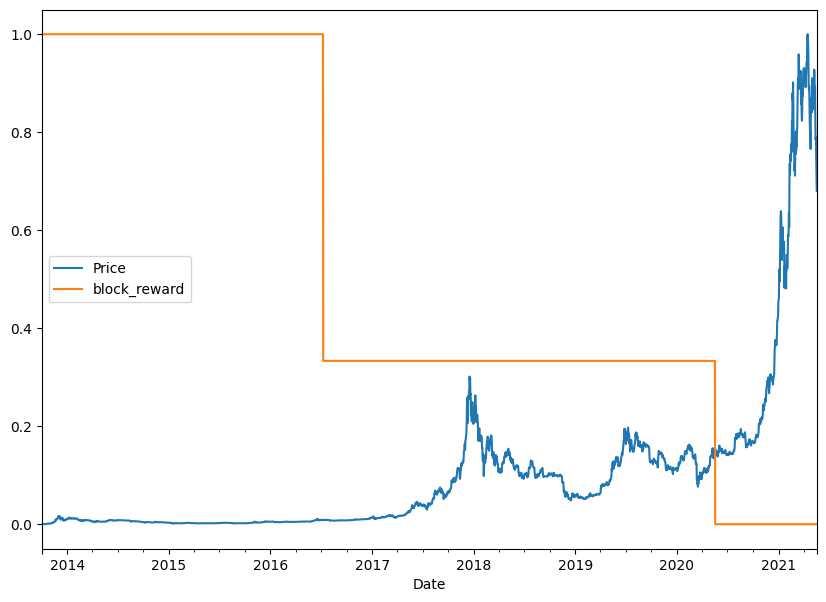

In [89]:
# Plot the blcok_reward vs price overtime
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                    columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset with pandas

Previously I've turned the univariate time series into windowed dataset using the functions above.

However, since this is multivariate data, these functions won't work for this data. We can use from pandas library the shift() method.

In [90]:
# Make a copy of the Bitcoin historical data with the block_reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [91]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What I've done with the data is to create a way to window the dataset directly from a pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [92]:
# Create X (windows) and y
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [93]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [94]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [95]:
# Set random seed
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae", "mse"]
)

# Fit the model
model_6.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(model_name=model_6.name)]
)

Epoch 1/100
 1/18 [>.............................] - ETA: 10s - loss: 4392.0283 - mae: 4392.0283 - mse: 39659176.0000

18/18 [==============================] - 3s 132ms/step - loss: 2568.0225 - mae: 2568.0225 - mse: 17627350.0000 - val_loss: 6086.1187 - val_mae: 6086.1187 - val_mse: 66998052.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 720.2593 - mae: 720.2593 - mse: 1632161.5000

18/18 [==============================] - 1s 40ms/step - loss: 399.0915 - mae: 399.0915 - mse: 576342.1875 - val_loss: 1218.2681 - val_mae: 1218.2681 - val_mse: 4634887.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 160.3207 - mae: 160.3207 - mse: 90399.7969

18/18 [==============================] - 1s 42ms/step - loss: 202.5131 - mae: 202.5131 - mse: 192600.3594 - val_loss: 1010.1949 - val_mae: 1010.1949 - val_mse: 3449064.0000
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 245.4255 - mae: 245.4255 - mse: 329904.2188

18/18 [==============================] - 1s 57ms/step - loss: 182.8741 - mae: 182.8741 - mse: 174521.0625 - val_loss: 990.7038 - val_mae: 990.7038 - val_mse: 3318973.7500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 200.1508 - mae: 200.1508 - mse: 147333.1562

18/18 [==============================] - 1s 59ms/step - loss: 176.1466 - mae: 176.1466 - mse: 160942.4844 - val_loss: 966.5354 - val_mae: 966.5354 - val_mse: 3109077.0000
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 170.9977 - mae: 170.9977 - mse: 144137.5469

18/18 [==============================] - 1s 63ms/step - loss: 174.1311 - mae: 174.1311 - mse: 161290.2969 - val_loss: 965.4352 - val_mae: 965.4352 - val_mse: 3156647.5000
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 214.1495 - mae: 214.1495 - mse: 325923.7500

18/18 [==============================] - 1s 58ms/step - loss: 171.0670 - mae: 171.0670 - mse: 157376.0938 - val_loss: 941.3209 - val_mae: 941.3209 - val_mse: 3001899.2500
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 166.7752 - mae: 166.7752 - mse: 151040.0312 - val_loss: 942.4731 - val_mae: 942.4731 - val_mse: 2880574.2500
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 164.2277 - mae: 164.2277 - mse: 146907.5625 - val_loss: 941.7678 - val_mae: 941.7678 - val_mse: 2824790.5000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 177.5282 - mae: 177.5282 - mse: 216983.2812

18/18 [==============================] - 1s 43ms/step - loss: 162.0804 - mae: 162.0804 - mse: 143864.4219 - val_loss: 903.1281 - val_mae: 903.1281 - val_mse: 2691105.5000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 172.8337 - mae: 172.8337 - mse: 127810.1953

18/18 [==============================] - 1s 41ms/step - loss: 158.9336 - mae: 158.9336 - mse: 138110.2344 - val_loss: 879.8746 - val_mae: 879.8746 - val_mse: 2631083.7500
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 157.2921 - mae: 157.2921 - mse: 134775.0625 - val_loss: 905.3665 - val_mae: 905.3665 - val_mse: 2584290.5000
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 116.6730 - mae: 116.6730 - mse: 92576.9453

18/18 [==============================] - 1s 42ms/step - loss: 154.0816 - mae: 154.0816 - mse: 130756.0859 - val_loss: 877.7075 - val_mae: 877.7075 - val_mse: 2471690.5000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 159.9468 - mae: 159.9468 - mse: 126387.9062

18/18 [==============================] - 1s 42ms/step - loss: 150.9494 - mae: 150.9494 - mse: 126187.8984 - val_loss: 876.3760 - val_mae: 876.3760 - val_mse: 2423284.2500
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 154.2240 - mae: 154.2240 - mse: 85154.9375

18/18 [==============================] - 1s 44ms/step - loss: 149.4738 - mae: 149.4738 - mse: 124142.0547 - val_loss: 853.9364 - val_mae: 853.9364 - val_mse: 2326209.2500
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 134.2069 - mae: 134.2069 - mse: 80026.1484

18/18 [==============================] - 1s 66ms/step - loss: 146.3430 - mae: 146.3430 - mse: 120452.3203 - val_loss: 820.9894 - val_mae: 820.9894 - val_mse: 2211894.0000
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 136.6159 - mae: 136.6159 - mse: 97107.5625

18/18 [==============================] - 1s 42ms/step - loss: 145.0464 - mae: 145.0464 - mse: 116807.3047 - val_loss: 801.8054 - val_mae: 801.8054 - val_mse: 2130851.2500
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 142.0042 - mae: 142.0042 - mse: 113300.1172 - val_loss: 821.2227 - val_mae: 821.2227 - val_mse: 2133469.2500
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 82.4891 - mae: 82.4891 - mse: 36042.2578

18/18 [==============================] - 1s 43ms/step - loss: 138.9285 - mae: 138.9285 - mse: 109303.2266 - val_loss: 789.9764 - val_mae: 789.9764 - val_mse: 2022488.0000
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 139.0083 - mae: 139.0083 - mse: 109669.8672 - val_loss: 810.9514 - val_mae: 810.9514 - val_mse: 2189148.7500
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 198.6200 - mae: 198.6200 - mse: 179902.1250

18/18 [==============================] - 1s 42ms/step - loss: 138.3531 - mae: 138.3531 - mse: 108471.3359 - val_loss: 750.0557 - val_mae: 750.0557 - val_mse: 1890981.6250
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 186.0186 - mae: 186.0186 - mse: 206055.5312

18/18 [==============================] - 1s 43ms/step - loss: 135.5289 - mae: 135.5289 - mse: 103330.8438 - val_loss: 742.6234 - val_mae: 742.6234 - val_mse: 1831295.1250
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 139.9846 - mae: 139.9846 - mse: 93759.7969

18/18 [==============================] - 1s 43ms/step - loss: 132.3297 - mae: 132.3297 - mse: 99584.8125 - val_loss: 739.4897 - val_mae: 739.4897 - val_mse: 1789464.8750
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 142.4575 - mae: 142.4575 - mse: 90887.2812

18/18 [==============================] - 1s 43ms/step - loss: 133.1423 - mae: 133.1423 - mse: 98895.8125 - val_loss: 730.7812 - val_mae: 730.7812 - val_mse: 1746563.3750
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 138.3552 - mae: 138.3552 - mse: 78981.1406

18/18 [==============================] - 1s 54ms/step - loss: 134.1901 - mae: 134.1901 - mse: 100348.2891 - val_loss: 726.7532 - val_mae: 726.7532 - val_mse: 1717602.1250
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 133.0037 - mae: 133.0037 - mse: 94752.2734

18/18 [==============================] - 1s 60ms/step - loss: 128.6151 - mae: 128.6151 - mse: 94049.0391 - val_loss: 720.0664 - val_mae: 720.0664 - val_mse: 1771345.3750
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 129.5426 - mae: 129.5426 - mse: 96043.6875 

18/18 [==============================] - 1s 60ms/step - loss: 129.5426 - mae: 129.5426 - mse: 96043.6875 - val_loss: 704.7401 - val_mae: 704.7401 - val_mse: 1703461.7500
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 130.5376 - mae: 130.5376 - mse: 85884.4297

18/18 [==============================] - 1s 59ms/step - loss: 125.6273 - mae: 125.6273 - mse: 91360.3047 - val_loss: 689.5813 - val_mae: 689.5813 - val_mse: 1598252.8750
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 118.2841 - mae: 118.2841 - mse: 80482.1328

18/18 [==============================] - 1s 46ms/step - loss: 124.0482 - mae: 124.0482 - mse: 89234.8906 - val_loss: 685.4300 - val_mae: 685.4300 - val_mse: 1569915.6250
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 145.1223 - mae: 145.1223 - mse: 114717.4219

18/18 [==============================] - 1s 44ms/step - loss: 126.2152 - mae: 126.2152 - mse: 89686.3984 - val_loss: 680.1464 - val_mae: 680.1464 - val_mse: 1546188.5000
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 122.1505 - mae: 122.1505 - mse: 86215.9062 - val_loss: 708.2319 - val_mae: 708.2319 - val_mse: 1604341.3750
Epoch 32/100
18/18 [==============================] - 0s 4ms/step - loss: 123.9117 - mae: 123.9117 - mse: 88405.7266 - val_loss: 696.7900 - val_mae: 696.7900 - val_mse: 1568801.1250
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 120.7824 - mae: 120.7824 - mse: 84212.3516 - val_loss: 709.3859 - val_mae: 709.3859 - val_mse: 1591743.2500
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 149.8036 - mae: 149.8036 - mse: 136869.6562

18/18 [==============================] - 1s 44ms/step - loss: 123.2484 - mae: 123.2484 - mse: 86861.5000 - val_loss: 655.6436 - val_mae: 655.6436 - val_mse: 1457227.8750
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 104.8794 - mae: 104.8794 - mse: 54841.9219

18/18 [==============================] - 1s 41ms/step - loss: 122.0859 - mae: 122.0859 - mse: 86746.5625 - val_loss: 654.2234 - val_mae: 654.2234 - val_mse: 1446658.2500
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 123.8014 - mae: 123.8014 - mse: 84567.2422 - val_loss: 721.7491 - val_mae: 721.7491 - val_mse: 1602426.2500
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7889 - mae: 155.7889 - mse: 120147.6094

18/18 [==============================] - 1s 41ms/step - loss: 120.2751 - mae: 120.2751 - mse: 82446.0859 - val_loss: 642.4907 - val_mae: 642.4907 - val_mse: 1440390.2500
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 110.8497 - mae: 110.8497 - mse: 74315.4219

18/18 [==============================] - 1s 42ms/step - loss: 118.7847 - mae: 118.7847 - mse: 83874.6797 - val_loss: 629.9567 - val_mae: 629.9567 - val_mse: 1390190.5000
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 135.4877 - mae: 135.4877 - mse: 111092.7656

18/18 [==============================] - 1s 44ms/step - loss: 116.3106 - mae: 116.3106 - mse: 80887.1328 - val_loss: 625.9569 - val_mae: 625.9569 - val_mse: 1373532.5000
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7418 - mae: 115.7418 - mse: 79764.5000 - val_loss: 626.8914 - val_mae: 626.8914 - val_mse: 1360262.2500
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 116.9516 - mae: 116.9516 - mse: 81128.5078 - val_loss: 645.0683 - val_mae: 645.0683 - val_mse: 1437156.6250
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 111.1794 - mae: 111.1794 - mse: 62785.7852

18/18 [==============================] - 1s 41ms/step - loss: 119.7908 - mae: 119.7908 - mse: 83499.4531 - val_loss: 615.3817 - val_mae: 615.3817 - val_mse: 1333914.2500
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 114.0242 - mae: 114.0242 - mse: 77327.8281 - val_loss: 635.5203 - val_mae: 635.5203 - val_mse: 1402078.1250
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 70.3275 - mae: 70.3275 - mse: 17199.3164

18/18 [==============================] - 1s 43ms/step - loss: 115.2000 - mae: 115.2000 - mse: 77900.6641 - val_loss: 611.3342 - val_mae: 611.3342 - val_mse: 1328681.8750
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 114.3774 - mae: 114.3774 - mse: 78743.4922 - val_loss: 615.3347 - val_mae: 615.3347 - val_mse: 1317112.7500
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 87.5726 - mae: 87.5726 - mse: 52058.1406

18/18 [==============================] - 1s 42ms/step - loss: 115.1086 - mae: 115.1086 - mse: 78493.9766 - val_loss: 603.0209 - val_mae: 603.0209 - val_mse: 1299550.0000
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 117.2921 - mae: 117.2921 - mse: 80564.4844 - val_loss: 726.0433 - val_mae: 726.0433 - val_mse: 1571260.1250
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 117.3506 - mae: 117.3506 - mse: 77924.8125 - val_loss: 739.2942 - val_mae: 739.2942 - val_mse: 1607005.3750
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 186.9258 - mae: 186.9258 - mse: 134321.3594

18/18 [==============================] - 1s 70ms/step - loss: 118.1359 - mae: 118.1359 - mse: 78241.4922 - val_loss: 600.9095 - val_mae: 600.9095 - val_mse: 1281644.8750
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 111.3201 - mae: 111.3201 - mse: 75730.0234 - val_loss: 640.0353 - val_mae: 640.0353 - val_mse: 1391646.1250
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1531 - mae: 113.1531 - mse: 76587.3594 - val_loss: 610.3461 - val_mae: 610.3461 - val_mse: 1287671.7500
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7787 - mae: 113.7787 - mse: 77597.5000 - val_loss: 611.3456 - val_mae: 611.3456 - val_mse: 1313146.5000
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 114.6279 - mae: 114.6279 - mse: 76865.6797 - val_loss: 619.0641 - val_mae: 619.0641 - val_mse: 1300239.2500
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 115.4244 - mae: 115.4244 - m

18/18 [==============================] - 1s 55ms/step - loss: 112.6879 - mae: 112.6879 - mse: 75612.7188 - val_loss: 600.0828 - val_mae: 600.0828 - val_mse: 1280710.5000
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5797 - mae: 109.5797 - mse: 73688.6484 - val_loss: 713.4178 - val_mae: 713.4178 - val_mse: 1591353.1250
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 116.9456 - mae: 116.9456 - mse: 78993.0156 - val_loss: 646.3500 - val_mae: 646.3500 - val_mse: 1390212.5000
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 95.2280 - mae: 95.2280 - mse: 35849.7031

18/18 [==============================] - 1s 58ms/step - loss: 116.0498 - mae: 116.0498 - mse: 75122.1875 - val_loss: 588.7048 - val_mae: 588.7048 - val_mse: 1238566.7500
Epoch 59/100
13/18 [====================>.........] - ETA: 0s - loss: 107.2764 - mae: 107.2764 - mse: 73752.6406

18/18 [==============================] - 1s 62ms/step - loss: 110.3901 - mae: 110.3901 - mse: 74085.5234 - val_loss: 585.2726 - val_mae: 585.2726 - val_mse: 1241393.0000
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 109.2723 - mae: 109.2723 - mse: 73228.1484 - val_loss: 603.0165 - val_mae: 603.0165 - val_mse: 1257911.1250
Epoch 61/100
14/18 [======================>.......] - ETA: 0s - loss: 109.7134 - mae: 109.7134 - mse: 74042.2031

18/18 [==============================] - 1s 60ms/step - loss: 110.0006 - mae: 110.0006 - mse: 74260.9453 - val_loss: 583.3234 - val_mae: 583.3234 - val_mse: 1225911.7500
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 108.6499 - mae: 108.6499 - mse: 71778.4609 - val_loss: 587.9641 - val_mae: 587.9641 - val_mse: 1242614.1250
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3605 - mae: 110.3605 - mse: 73797.9219 - val_loss: 620.3966 - val_mae: 620.3966 - val_mse: 1286237.8750
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9295 - mae: 110.9295 - mse: 73382.3516 - val_loss: 639.9719 - val_mae: 639.9719 - val_mse: 1325542.5000
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 112.9849 - mae: 112.9849 - mse: 74835.1797 - val_loss: 592.2450 - val_mae: 592.2450 - val_mse: 1247451.1250
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 117.9975 - mae: 117.9975 - mse: 

18/18 [==============================] - 1s 45ms/step - loss: 109.4342 - mae: 109.4342 - mse: 72510.4219 - val_loss: 583.0902 - val_mae: 583.0902 - val_mse: 1215695.2500
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5408 - mae: 108.5408 - mse: 71642.4062 - val_loss: 645.2667 - val_mae: 645.2667 - val_mse: 1369149.0000
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 115.3525 - mae: 115.3525 - mse: 72387.9219 - val_loss: 712.2962 - val_mae: 712.2962 - val_mse: 1560941.3750
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 125.9562 - mae: 125.9562 - mse: 82701.2578 - val_loss: 660.1707 - val_mae: 660.1707 - val_mse: 1408158.7500
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 122.0062 - mae: 122.0062 - mse: 80837.2031 - val_loss: 589.5712 - val_mae: 589.5712 - val_mse: 1242121.0000
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 111.5673 - mae: 111.5673 - m

18/18 [==============================] - 1s 42ms/step - loss: 109.8384 - mae: 109.8384 - mse: 72170.7812 - val_loss: 579.4938 - val_mae: 579.4938 - val_mse: 1206855.3750
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1873 - mae: 108.1873 - mse: 71171.6484 - val_loss: 590.2078 - val_mae: 590.2078 - val_mse: 1237699.5000
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 165.8419 - mae: 165.8419 - mse: 174721.7188

18/18 [==============================] - 1s 43ms/step - loss: 108.9767 - mae: 108.9767 - mse: 72318.7109 - val_loss: 577.9447 - val_mae: 577.9447 - val_mse: 1210503.2500
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6304 - mae: 108.6304 - mse: 71604.7812 - val_loss: 596.9366 - val_mae: 596.9366 - val_mse: 1231316.1250
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3367 - mae: 110.3367 - mse: 72976.9531 - val_loss: 601.5720 - val_mae: 601.5720 - val_mse: 1256041.6250
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7106 - mae: 108.7106 - mse: 71237.9141 - val_loss: 579.6125 - val_mae: 579.6125 - val_mse: 1212484.1250
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 105.6056 - mae: 105.6056 - mse: 48766.3125

18/18 [==============================] - 1s 42ms/step - loss: 110.4703 - mae: 110.4703 - mse: 72370.3359 - val_loss: 574.3162 - val_mae: 574.3162 - val_mse: 1193291.2500
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4018 - mae: 108.4018 - mse: 72747.3672 - val_loss: 629.3832 - val_mae: 629.3832 - val_mse: 1317399.7500
Epoch 80/100
 1/18 [>.............................] - ETA: 0s - loss: 118.9342 - mae: 118.9342 - mse: 128261.0391

18/18 [==============================] - 1s 44ms/step - loss: 109.5151 - mae: 109.5151 - mse: 72316.9922 - val_loss: 573.1201 - val_mae: 573.1201 - val_mse: 1192471.0000
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 93.5627 - mae: 93.5627 - mse: 43241.6016

18/18 [==============================] - 1s 43ms/step - loss: 106.7132 - mae: 106.7132 - mse: 70480.2266 - val_loss: 571.5455 - val_mae: 571.5455 - val_mse: 1192343.2500
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 193.0415 - mae: 193.0415 - mse: 234852.3125

18/18 [==============================] - 1s 43ms/step - loss: 114.7752 - mae: 114.7752 - mse: 76270.8906 - val_loss: 571.0660 - val_mae: 571.0660 - val_mse: 1190136.0000
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4227 - mae: 111.4227 - mse: 73039.9219 - val_loss: 666.9783 - val_mae: 666.9783 - val_mse: 1412473.7500
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 112.1948 - mae: 112.1948 - mse: 72365.2109 - val_loss: 590.5544 - val_mae: 590.5544 - val_mse: 1228662.2500
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 107.6141 - mae: 107.6141 - mse: 70778.0625 - val_loss: 585.7549 - val_mae: 585.7549 - val_mse: 1205210.3750
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4419 - mae: 108.4419 - mse: 70253.8047 - val_loss: 612.2909 - val_mae: 612.2909 - val_mse: 1256679.2500
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 107.4855 - mae: 107.4855 - m

In [96]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 666.8744 - mae: 666.8744 - mse: 1372108.7500


[666.8743896484375, 666.8743896484375, 1372108.75]

In [97]:
# Load in and evaluating the best peforming model
model_6 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 571.0660 - mae: 571.0660 - mse: 1190135.8750


[571.0659790039062, 571.0659790039062, 1190135.875]

In [98]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8903.813, 8788.859, 9022.638, 8828.661, 8751.389, 8749.428,
       8711.442, 8542.257, 8476.3  , 8536.033], dtype=float32)>

In [99]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 571.0659592443233,
 'mse': 1190135.9117902375,
 'rmse': 1090.933504751888,
 'mape': 2.560029119990562,
 'mase': 1.003204646717943}

In [100]:
model_1_results

{'mae': 564.527951111124,
 'mse': 1153689.8980102974,
 'rmse': 1074.0995754632331,
 'mape': 2.5373140770929306,
 'mase': 0.9917191466416637}

## Model 7: N-BEATS algorithm

I will try to replicate the following algorithm from the following paper: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, I've got to create it.

To create custom layers and models in TensorFlow I will use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [101]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Test the N-Beats layer by using some dummy inputs and outputs

In [102]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [103]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [104]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# There are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.6713326  -0.23288043  0.23968855 -0.33548963  0.5912976  -0.11686112
  0.33822444]
Forecast: -0.07134926319122314


### Preparing data for the N-BEATS algorithm using `tf.data`

To make the input data load as fast as possible I need to be adhering to the performant data pipeline steps in the tf.data guide.

In [105]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [106]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=(i+1))
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [107]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test stes
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [108]:
# Time to make the dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping togheter -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [109]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before I can craft the N-BEATS model, I need two layers for the residual connections (substract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture.

In [110]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

# Substract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm
1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

# Set the random seed
tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name="InitialBlock"
)

# 2. Create input to stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)): # first stack is already in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(
    train_dataset,
    epochs=N_EPOCHS,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor="val_loss",
                  patience=200,
                  restore_best_weights=True
               ),
               tf.keras.callbacks.ReduceLROnPlateau(
                   monitor="val_loss",
                   patience=100,
                   verbose=1
               ),
               create_model_checkpoint(model_name=model_7.name)
    ]
)

Epoch 1/5000
3/3 [==============================] - ETA: 0s - loss: 3326.3362

3/3 [==============================] - 68s 17s/step - loss: 3326.3362 - val_loss: 485662.7188 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - ETA: 0s - loss: 14372.8760

3/3 [==============================] - 38s 17s/step - loss: 14372.8760 - val_loss: 2041.6207 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 6s 2s/step - loss: 1072.2632 - val_loss: 8103.0996 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 7s 2s/step - loss: 879.6360 - val_loss: 17330.8516 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 7s 2s/step - loss: 5316.9468 - val_loss: 2367.0483 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 7s 2s/step - loss: 1166.1744 - val_loss: 4432.5757 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 8s 3s/step - loss: 492.0197 - val_loss: 4115.7446 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 6s 2s/step - loss: 1344.9883 - val_loss: 6093.9170 - lr: 0.0010
Epoch 9/5000
3/3 [==============================] - 6s 2s/step - loss: 1525.4275 - val_loss: 10571.3604 - lr: 0.0010
Epoch 10/5000
3/3 [==============================] - 8s 3s/step - loss: 1613.3138 

3/3 [==============================] - 38s 16s/step - loss: 4591.0337 - val_loss: 1101.4987 - lr: 0.0010
Epoch 13/5000
3/3 [==============================] - 9s 3s/step - loss: 683.9041 - val_loss: 5671.3525 - lr: 0.0010
Epoch 14/5000
3/3 [==============================] - 6s 2s/step - loss: 760.1557 - val_loss: 1328.7759 - lr: 0.0010
Epoch 15/5000
3/3 [==============================] - 7s 2s/step - loss: 407.7242 - val_loss: 1155.5725 - lr: 0.0010
Epoch 16/5000
3/3 [==============================] - 6s 2s/step - loss: 457.4042 - val_loss: 1589.5341 - lr: 0.0010
Epoch 17/5000
3/3 [==============================] - ETA: 0s - loss: 478.2214

3/3 [==============================] - 35s 16s/step - loss: 478.2214 - val_loss: 1059.1084 - lr: 0.0010
Epoch 18/5000
3/3 [==============================] - 8s 3s/step - loss: 425.5983 - val_loss: 1136.7300 - lr: 0.0010
Epoch 19/5000
3/3 [==============================] - ETA: 0s - loss: 244.6255

3/3 [==============================] - 36s 16s/step - loss: 244.6255 - val_loss: 1048.3881 - lr: 0.0010
Epoch 20/5000
3/3 [==============================] - 9s 3s/step - loss: 221.2372 - val_loss: 1088.1888 - lr: 0.0010
Epoch 21/5000
3/3 [==============================] - 6s 2s/step - loss: 216.1135 - val_loss: 1067.3691 - lr: 0.0010
Epoch 22/5000
3/3 [==============================] - 6s 2s/step - loss: 224.4249 - val_loss: 1141.7845 - lr: 0.0010
Epoch 23/5000
3/3 [==============================] - ETA: 0s - loss: 200.9529

3/3 [==============================] - 35s 15s/step - loss: 200.9529 - val_loss: 1015.4456 - lr: 0.0010
Epoch 24/5000
3/3 [==============================] - 9s 2s/step - loss: 188.3388 - val_loss: 1101.3667 - lr: 0.0010
Epoch 25/5000
3/3 [==============================] - 6s 2s/step - loss: 181.0606 - val_loss: 1025.2990 - lr: 0.0010
Epoch 26/5000
3/3 [==============================] - 6s 2s/step - loss: 183.8152 - val_loss: 1018.9280 - lr: 0.0010
Epoch 27/5000
3/3 [==============================] - 7s 2s/step - loss: 178.4319 - val_loss: 1020.7429 - lr: 0.0010
Epoch 28/5000
3/3 [==============================] - ETA: 0s - loss: 191.7174

3/3 [==============================] - 35s 16s/step - loss: 191.7174 - val_loss: 987.2843 - lr: 0.0010
Epoch 29/5000
3/3 [==============================] - ETA: 0s - loss: 188.0323

3/3 [==============================] - 36s 17s/step - loss: 188.0323 - val_loss: 941.7670 - lr: 0.0010
Epoch 30/5000
3/3 [==============================] - 8s 3s/step - loss: 181.2963 - val_loss: 994.6315 - lr: 0.0010
Epoch 31/5000
3/3 [==============================] - ETA: 0s - loss: 173.8040

3/3 [==============================] - 35s 16s/step - loss: 173.8040 - val_loss: 928.4677 - lr: 0.0010
Epoch 32/5000
3/3 [==============================] - ETA: 0s - loss: 175.4457

3/3 [==============================] - 34s 16s/step - loss: 175.4457 - val_loss: 921.7310 - lr: 0.0010
Epoch 33/5000
3/3 [==============================] - ETA: 0s - loss: 181.1676

3/3 [==============================] - 36s 16s/step - loss: 181.1676 - val_loss: 913.4337 - lr: 0.0010
Epoch 34/5000
3/3 [==============================] - 11s 3s/step - loss: 186.9031 - val_loss: 960.6632 - lr: 0.0010
Epoch 35/5000
3/3 [==============================] - ETA: 0s - loss: 173.4883

3/3 [==============================] - 34s 16s/step - loss: 173.4883 - val_loss: 873.2810 - lr: 0.0010
Epoch 36/5000
3/3 [==============================] - 8s 3s/step - loss: 171.3277 - val_loss: 911.3492 - lr: 0.0010
Epoch 37/5000
3/3 [==============================] - 7s 2s/step - loss: 166.7938 - val_loss: 883.7775 - lr: 0.0010
Epoch 38/5000
3/3 [==============================] - 8s 2s/step - loss: 179.4426 - val_loss: 875.4678 - lr: 0.0010
Epoch 39/5000
3/3 [==============================] - ETA: 0s - loss: 177.1112

3/3 [==============================] - 36s 17s/step - loss: 177.1112 - val_loss: 848.1954 - lr: 0.0010
Epoch 40/5000
3/3 [==============================] - 8s 3s/step - loss: 188.9260 - val_loss: 887.1034 - lr: 0.0010
Epoch 41/5000
3/3 [==============================] - ETA: 0s - loss: 178.0482

3/3 [==============================] - 33s 15s/step - loss: 178.0482 - val_loss: 816.7971 - lr: 0.0010
Epoch 42/5000
3/3 [==============================] - 8s 3s/step - loss: 179.1718 - val_loss: 846.5375 - lr: 0.0010
Epoch 43/5000
3/3 [==============================] - ETA: 0s - loss: 176.8134

3/3 [==============================] - 33s 15s/step - loss: 176.8134 - val_loss: 809.3161 - lr: 0.0010
Epoch 44/5000
3/3 [==============================] - 8s 3s/step - loss: 187.4571 - val_loss: 814.4833 - lr: 0.0010
Epoch 45/5000
3/3 [==============================] - ETA: 0s - loss: 193.7715

3/3 [==============================] - 34s 16s/step - loss: 193.7715 - val_loss: 789.5465 - lr: 0.0010
Epoch 46/5000
3/3 [==============================] - 7s 2s/step - loss: 184.0976 - val_loss: 859.5331 - lr: 0.0010
Epoch 47/5000
3/3 [==============================] - 8s 2s/step - loss: 169.6331 - val_loss: 789.9218 - lr: 0.0010
Epoch 48/5000
3/3 [==============================] - ETA: 0s - loss: 183.7534

3/3 [==============================] - 33s 15s/step - loss: 183.7534 - val_loss: 786.4189 - lr: 0.0010
Epoch 49/5000
3/3 [==============================] - ETA: 0s - loss: 194.4550

3/3 [==============================] - 36s 17s/step - loss: 194.4550 - val_loss: 769.9011 - lr: 0.0010
Epoch 50/5000
3/3 [==============================] - 8s 3s/step - loss: 181.5948 - val_loss: 844.9711 - lr: 0.0010
Epoch 51/5000
3/3 [==============================] - ETA: 0s - loss: 164.1934

3/3 [==============================] - 35s 16s/step - loss: 164.1934 - val_loss: 767.5028 - lr: 0.0010
Epoch 52/5000
3/3 [==============================] - ETA: 0s - loss: 172.9921

3/3 [==============================] - 34s 16s/step - loss: 172.9921 - val_loss: 764.9838 - lr: 0.0010
Epoch 53/5000
3/3 [==============================] - 7s 2s/step - loss: 189.9716 - val_loss: 778.7670 - lr: 0.0010
Epoch 54/5000
3/3 [==============================] - 8s 3s/step - loss: 208.7365 - val_loss: 836.1284 - lr: 0.0010
Epoch 55/5000
3/3 [==============================] - 6s 2s/step - loss: 178.5365 - val_loss: 779.2552 - lr: 0.0010
Epoch 56/5000
3/3 [==============================] - 8s 2s/step - loss: 154.4887 - val_loss: 769.1939 - lr: 0.0010
Epoch 57/5000
3/3 [==============================] - 8s 3s/step - loss: 153.7146 - val_loss: 847.2519 - lr: 0.0010
Epoch 58/5000
3/3 [==============================] - ETA: 0s - loss: 209.2192

3/3 [==============================] - 34s 16s/step - loss: 209.2192 - val_loss: 739.9543 - lr: 0.0010
Epoch 59/5000
3/3 [==============================] - 8s 3s/step - loss: 230.9939 - val_loss: 746.6514 - lr: 0.0010
Epoch 60/5000
3/3 [==============================] - 7s 2s/step - loss: 198.2028 - val_loss: 911.0644 - lr: 0.0010
Epoch 61/5000
3/3 [==============================] - 8s 3s/step - loss: 153.1809 - val_loss: 791.9158 - lr: 0.0010
Epoch 62/5000
3/3 [==============================] - 6s 2s/step - loss: 194.8321 - val_loss: 780.5124 - lr: 0.0010
Epoch 63/5000
3/3 [==============================] - 8s 2s/step - loss: 259.0242 - val_loss: 741.9319 - lr: 0.0010
Epoch 64/5000
3/3 [==============================] - 8s 3s/step - loss: 215.3979 - val_loss: 1152.0679 - lr: 0.0010
Epoch 65/5000
3/3 [==============================] - 6s 2s/step - loss: 148.1470 - val_loss: 792.8371 - lr: 0.0010
Epoch 66/5000
3/3 [==============================] - 6s 2s/step - loss: 134.3682 - val_loss

3/3 [==============================] - 40s 18s/step - loss: 144.2697 - val_loss: 732.9698 - lr: 0.0010
Epoch 68/5000
3/3 [==============================] - 8s 3s/step - loss: 150.9572 - val_loss: 968.3703 - lr: 0.0010
Epoch 69/5000
3/3 [==============================] - 7s 2s/step - loss: 245.5101 - val_loss: 748.8524 - lr: 0.0010
Epoch 70/5000
3/3 [==============================] - 7s 2s/step - loss: 214.6798 - val_loss: 750.0705 - lr: 0.0010
Epoch 71/5000
3/3 [==============================] - 8s 3s/step - loss: 177.2313 - val_loss: 810.2725 - lr: 0.0010
Epoch 72/5000
3/3 [==============================] - ETA: 0s - loss: 151.4995

3/3 [==============================] - 34s 16s/step - loss: 151.4995 - val_loss: 713.3276 - lr: 0.0010
Epoch 73/5000
3/3 [==============================] - ETA: 0s - loss: 167.1139

3/3 [==============================] - 35s 16s/step - loss: 167.1139 - val_loss: 706.9280 - lr: 0.0010
Epoch 74/5000
3/3 [==============================] - 8s 2s/step - loss: 191.3099 - val_loss: 725.5118 - lr: 0.0010
Epoch 75/5000
3/3 [==============================] - 8s 3s/step - loss: 216.5119 - val_loss: 861.6096 - lr: 0.0010
Epoch 76/5000
3/3 [==============================] - 6s 2s/step - loss: 160.5367 - val_loss: 722.5355 - lr: 0.0010
Epoch 77/5000
3/3 [==============================] - 6s 2s/step - loss: 149.0348 - val_loss: 707.8403 - lr: 0.0010
Epoch 78/5000
3/3 [==============================] - 8s 3s/step - loss: 158.2831 - val_loss: 743.3107 - lr: 0.0010
Epoch 79/5000
3/3 [==============================] - 7s 2s/step - loss: 194.7084 - val_loss: 713.8318 - lr: 0.0010
Epoch 80/5000
3/3 [==============================] - 8s 3s/step - loss: 192.2931 - val_loss: 707.2783 - lr: 0.0010
Epoch 81/5000
3/3 [==============================] - 6s 2s/step - loss: 177.8057 - val_loss:

3/3 [==============================] - 35s 16s/step - loss: 151.0402 - val_loss: 696.4741 - lr: 0.0010
Epoch 83/5000
3/3 [==============================] - 6s 2s/step - loss: 151.0498 - val_loss: 696.9246 - lr: 0.0010
Epoch 84/5000
3/3 [==============================] - 9s 3s/step - loss: 166.0207 - val_loss: 716.2601 - lr: 0.0010
Epoch 85/5000
3/3 [==============================] - 6s 2s/step - loss: 192.5302 - val_loss: 727.0378 - lr: 0.0010
Epoch 86/5000
3/3 [==============================] - ETA: 0s - loss: 179.9784

3/3 [==============================] - 34s 16s/step - loss: 179.9784 - val_loss: 694.4737 - lr: 0.0010
Epoch 87/5000
3/3 [==============================] - 7s 2s/step - loss: 172.7826 - val_loss: 733.8271 - lr: 0.0010
Epoch 88/5000
3/3 [==============================] - ETA: 0s - loss: 160.8962

3/3 [==============================] - 35s 15s/step - loss: 160.8962 - val_loss: 688.3388 - lr: 0.0010
Epoch 89/5000
3/3 [==============================] - 9s 3s/step - loss: 160.1924 - val_loss: 703.2172 - lr: 0.0010
Epoch 90/5000
3/3 [==============================] - 6s 2s/step - loss: 157.8703 - val_loss: 690.5994 - lr: 0.0010
Epoch 91/5000
3/3 [==============================] - 6s 2s/step - loss: 173.9384 - val_loss: 689.0068 - lr: 0.0010
Epoch 92/5000
3/3 [==============================] - ETA: 0s - loss: 180.7984

3/3 [==============================] - 35s 16s/step - loss: 180.7984 - val_loss: 681.2042 - lr: 0.0010
Epoch 93/5000
3/3 [==============================] - 6s 2s/step - loss: 184.1541 - val_loss: 772.6151 - lr: 0.0010
Epoch 94/5000
3/3 [==============================] - 9s 2s/step - loss: 153.7832 - val_loss: 686.1185 - lr: 0.0010
Epoch 95/5000
3/3 [==============================] - 6s 2s/step - loss: 150.2264 - val_loss: 691.4460 - lr: 0.0010
Epoch 96/5000
3/3 [==============================] - 6s 2s/step - loss: 153.2179 - val_loss: 698.6072 - lr: 0.0010
Epoch 97/5000
3/3 [==============================] - 8s 3s/step - loss: 178.8561 - val_loss: 683.1337 - lr: 0.0010
Epoch 98/5000
3/3 [==============================] - ETA: 0s - loss: 187.6283

3/3 [==============================] - 33s 15s/step - loss: 187.6283 - val_loss: 678.9951 - lr: 0.0010
Epoch 99/5000
3/3 [==============================] - 7s 2s/step - loss: 176.4794 - val_loss: 758.9600 - lr: 0.0010
Epoch 100/5000
3/3 [==============================] - ETA: 0s - loss: 150.7888

3/3 [==============================] - 36s 16s/step - loss: 150.7888 - val_loss: 676.3120 - lr: 0.0010
Epoch 101/5000
3/3 [==============================] - 9s 3s/step - loss: 150.2484 - val_loss: 680.3082 - lr: 0.0010
Epoch 102/5000
3/3 [==============================] - 6s 2s/step - loss: 154.4911 - val_loss: 694.7413 - lr: 0.0010
Epoch 103/5000
3/3 [==============================] - 8s 3s/step - loss: 184.9960 - val_loss: 689.7824 - lr: 0.0010
Epoch 104/5000
3/3 [==============================] - ETA: 0s - loss: 178.7650

3/3 [==============================] - 33s 15s/step - loss: 178.7650 - val_loss: 672.7398 - lr: 0.0010
Epoch 105/5000
1/3 [=========>....................] - ETA: 5s - loss: 15.6097

In [ ]:
# Evaluate N-BEats model on the test dataset
model_7 = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_7_NBEATS")
model_7.evaluate(test_dataset)

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(
    y_true=y_test,
    y_pred=model_7_preds
)
model_7_results

In [ ]:
model_1_results, naive_results

### Plotting the N-BEATS architecture I've created

In [ ]:
# Plot the N-BEATS model and inspect the arhictecure
tf.keras.utils.plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models togheter)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]
                        ):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned: 
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty liust for trained ensemble models
  ensemble_models=[]

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing the model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=["mae", "mse"]
      )

      # Fit the current model
      model.fit(
          train_dataset,
          epochs=num_epochs,
          verbose=0,
          validation_data=test_data,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=200,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                patience=100,
                                                verbose=1)
                     ]
      )

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=10,
                                      num_epochs=1000
                                      )

## Make predictions with the ensemble models

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(
    ensemble_models=ensemble_models,
    data=test_dataset
)
ensemble_preds

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds
                                  )
ensemble_results

The  ensemble preds come out in multiple dimensions but to combine into point predictions we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

In [ ]:
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results_mean

In [ ]:
ensemble_results_median = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results_median

In [ ]:
model_1_results

Plotting the prediction intervals (uncertainty estimates) of our ensemble
So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialzed models
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)
* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [ ]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std
  
  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)
lower, upper

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_media = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, I'll use fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Interval")
plt.legend(loc="upper left", fontsize=14)

**Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Model 9: Train a model on the full historical data to make predictions into the future

In [ ]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

In [ ]:
X_all[:10], y_all[:10]

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(HORIZON),

])

# Compile the model
model_9.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)

# Fit the model
model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

In [ ]:
# How many timestesp to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [ ]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE numer of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [ ]:
# Make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
bitcoin_prices_windowed.tail()

### Plot future forecasts

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timestpes (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

In [ ]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

In [ ]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_prices[-1])
next_time_steps, future_forecast

In [ ]:
# Plot future price prediction of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_prices, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Same as model 1 (but with turkey data - turkey problem)

In [ ]:
# Let's introduce a turkey problem to the BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [ ]:
# Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam()
)
turkey_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[create_model_checkpoint(turkey_model.name)]
)

In [ ]:
# Evaluate the model on test data
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model(GOOGLE_DRIVE_PATH + "/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

In [ ]:
model_1_results

In [ ]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):], 
                 format="-",
                 label="Turkey Test Data", 
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare results

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)                            

In [ ]:
# Sort model results by MAE and plot them 
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");